In [1]:
import requests as rq
from urllib.parse import quote
import pandas as pd
import re
import time
import random
import requests as rq
import bs4
import json
from urllib.parse import quote
import json_repair 
import time
import random
from fake_useragent import UserAgent
import os


In [3]:
class PhoneSpecsHandler:
    """
    A class that handles the retrieval of phone specifications using an API.

    Attributes:
        api (str): The URL of the API.
        headers (dict): The headers to be used for the requests.
        filename (str): The name of the file to save the retrieved data.

    Methods:
        get_phone_brands: Retrieves the available phone brands from the API.
        get_phone_models: Retrieves the phone models for a specific brand from the API.
        get_phone_specs: Retrieves the specifications of a specific phone from the API.
        update_all_data: Retrieves the specifications of all phones from the API.
        save_data: Saves the retrieved phone specifications to a JSON file.
    """

    def __init__(self, filename='phone_data.json'):
        self.api = 'https://phone-specs-api.vercel.app'
        self.headers = {'Content-Type': 'application/json',
                        'User-Agent': 'Mozilla/5.0'}
        self.filename = filename

        try:
            with open(self.filename, 'r') as f:
                self.data = json.load(f)
        except Exception as e:
            print(f'[Error: {e}]: Creating new file...')
            self.data = dict()

            # save the file
            self.save_data()


        

    def __get(self, url):
        """
        Retrieves the JSON response from the API.

        Args:
            url (str): The URL to be requested.

        Returns:
            dict: The JSON response from the API.
        """

        # throttle the requests to avoid getting blocked
        # add random delay between 0.5 and 2 seconds
        start = time.time()
        response = rq.get(url, headers=self.headers, timeout=10).json()
        end = time.time()

        duration = end - start
        if duration < 2:
            d = int((2 - duration)*1000)
            time.sleep(random.randint(d, d + 500)/1000)

        return response
    
    def __try_get(self, url):
        retries = 0
        while True:
            if retries == 5:
                print(f'[Error: {result["error"]}]: Retries exceeded. Skipping...')
                return None
            
            try:
                result = self.__get(url)

                if str(result['status']) == 'True':
                    return result
                elif 'Please provide a valid phone slug!' in result['error']:                
                    print(f'[Error: {result["error"]}]: Retrying in 5s...')
                    retries += 1
                    time.sleep(5)

            except Exception as e:
                print(f'[Error: {e.args[0]}]: Retrying in 5s...')
                retries += 1
                time.sleep(5)                


    def get_phone_brands(self):
        """
        Retrieves the available phone brands from the API.

        Returns:
            dict: The JSON response containing the available phone brands.
        """
        url = self.api + '/brands'
        response = self.__try_get(url)
        
        return response

    def get_phone_models(self, brand_name, brand_id):
        """
        Retrieves the phone models for a specific brand from the API.

        Args:
            brand_name (str): The name of the phone brand.
            brand_id (int): The ID of the phone brand.

        Returns:
            dict: The JSON response containing the phone models for the specified brand.
        """
        url = self.api + f'/brands/{quote(brand_name.lower().replace(" ", "_"))}-phones-{brand_id}'
        phones = self.__try_get(url)
        
        print(phones, url, sep='\n')

        last_page = int(phones['data']['last_page']) 

        print(f'last page: {last_page}')
        if last_page == 1:
            return phones

        for page in range(1, last_page):
            url_page = self.api + f'/brands/{quote(brand_name.lower().replace(" ", "_"))}-phones-f-{brand_id}-0-p{page+1}'
            response_page = self.__try_get(url_page)

            print(phones)

            phones['data']['phones'].extend(response_page['data']['phones'])

        phones['data'].pop('current_page')
        phones['data'].pop('last_page')

        return phones
    
    def get_phone_models(self, brand_json):
            """
            Retrieves the phone models for a given brand from the GSMArena API.

            Args:
                brand_json (dict): The JSON response containing the brand information.

            Returns:
                dict: The updated brand JSON response with the phone models.

            """

            phones = self.__try_get(brand_json['detail'])          

            # Use re.search to find the first match
            match = re.search(r"(.*?)-(\d+)", brand_json['brand_slug'])

            last_page = int(phones['data']['last_page']) 

            if match:
                # Extract the groups from the match
                first_part = match.group(1)  # Text before the last hyphen
                number = int(match.group(2))  # Number after the last hyphen

                print(f'Page 1 out of {last_page} for {brand_json["brand_name"]} is processing.')

                for page in range(1, last_page):
                    url_page = self.api + f'/brands/{quote(first_part)}-f-{number}-0-p{page+1}'
                    response_page = self.__try_get(url_page)

                    if response_page:
                        phones['data']['phones'].extend(response_page['data']['phones'])
                        print(f'Page {page+1} out of {last_page} done.')
                    else:
                        print(f'Page {page+1} out of {last_page} failed to process. Skipping...')


            phones['data'].pop('current_page')
            phones['data'].pop('last_page')

            return phones
    
    def get_phone_specs(self, phone_name):
        """
        Retrieves the specifications of a specific phone from the API.

        Args:
            phone_name (str): The name of the phone.

        Returns:
            dict: The JSON response containing the specifications of the specified phone.
        """
        url = self.api + f'/{quote(phone_name)}'
        response = self.__try_get(url)
        
        return response
    
    def get_result(self, phone_name):
        """
        Retrieves the search results for a specific phone from the API.

        Args:
            phone_name (str): The name of the phone to search for.

        Returns:
            dict: The JSON response containing the search results for the specified phone.
        """
        url = self.api + f'/search?query={quote(phone_name)}'
        response = self.__try_get(url)

        return response
    
    def update_all_data(self, forced=False):
        print('Phone specs scraping at 2s delay per request. Please wait...')

        if forced:
            self.data = dict()

        # brands = self.get_phone_brands()['data'][8:9]
        brands = self.get_phone_brands()['data']


        phone_sum =  sum([int(x) for x in [brand['device_count'] for brand in brands]])

        
        print(f'There are {phone_sum - self.count_data()} phones to be processed.\nNew phones catalog count: {phone_sum}\nOld phones catalog count: {self.count_data()}')

        if phone_sum-self.count_data() == 0:
            brands_len += 1
            print(f'[100% done]: No new phones to be processed. Done processing.')
            return self.data

        brands_len = len(brands)

        current_phone = 0
        total_time = 0
        
        for i, models in enumerate(brands):
            if self.data.get(models["brand_name"]) is None:
                self.data[models["brand_name"]] = {}

            if int(models['device_count']) == len(self.data[models["brand_name"]]):
                current_phone += int(models['device_count'])
                print(f'[{round(((current_phone)/phone_sum)*100, 4): 0.4f}% done; {current_phone}/{phone_sum} phones]: No new {models["brand_name"]} models to be processed. {models["brand_name"]} done processing, {brands_len - i} brands left.')
                continue

            phones = self.get_phone_models(models)['data']['phones']
            phones_len = len(phones)
            

            for j, phone in enumerate(phones):
                if phone['slug'] in self.data[models["brand_name"]].keys(): 
                    if self.data[models["brand_name"]][phone['slug']]['specifications']['Launch']['Status'][0].lower().find("coming soon") != -1:
                        print(f'[COMING SOON]: Trying to update {phone["phone_name"]}...')
                    else:
                        print(f'[{round(((current_phone := current_phone + 1)/phone_sum)*100, 4): 0.4f}% done; {j+1}/{phones_len} {models["brand_name"]} phones; {current_phone}/{phone_sum} phones]: {phone["phone_name"]} already exists. Skipping...')
                        continue


                # initial time
                start = time.time()
                
                specs = self.__try_get(phone['detail'])     
                if specs:        
                    self.data[models["brand_name"]][phone['slug']] = specs['data']
                    # clean all phones' specs data
                    self.data[models["brand_name"]][phone['slug']]['specifications'] = {j['title']: {k['key']: k['val'] for k in j['specs']} for j in  specs['data']['specifications']}

                    # end time
                    end = time.time()
                    remaining_time = ((total_time := total_time + end - start) / (j + 1)) * (phone_sum - (j + 1))
                    eta = time.time() + remaining_time

                    # convert hours to hours and minutes and seconds
                    print(f'[{round(((current_phone := current_phone + 1)/phone_sum)*100, 4): 0.4f}% done; ETA: {time.strftime("%I:%M:%S %p", time.localtime(eta))}, Remaining Time: {time.strftime("%H:%M:%S", time.gmtime(remaining_time))}; {j+1}/{phones_len} {models["brand_name"]} phones; {end-start:.3f}s; {current_phone}/{phone_sum} phones]: {phone["phone_name"]} done processing.')                
                else:
                    print(f'[{round(((current_phone := current_phone + 1)/phone_sum)*100, 4): 0.4f}% done; {j+1}/{phones_len} {models["brand_name"]} phones; {current_phone}/{phone_sum} phones]: {phone["phone_name"]} failed to process. Skipping...')


            print(f'[{round(((current_phone)/phone_sum)*100, 4): 0.4f}% done; {j+1}/{phones_len} {models["brand_name"]} phones; {current_phone}/{phone_sum} phones]: {models["brand_name"]} done processing, {brands_len - i} brands left.')

            # process/ normalize the data

        print(f'[100% done; {current_phone}/{phone_sum} phones]: Done processing.')


        return self.data
    

    def count_data(self):
        return sum([len(self.data[brand]) for brand in self.data])
            

    def save_data(self, filename = 'phone_data.json', forced_normalize = False):
        # open the previous file and store it to a variable

        __temp_data = dict()
        print('Loading the previous data...')
        with open(self.filename, 'r') as f:
            __temp_data = json.load(f)

        print('Processing the data...')
        

        for brand in __temp_data:
            for phone in __temp_data[brand]:
                if phone not in self.data[brand] or forced_normalize:
                    try:
                        # Normalize the announced date
                        self.data[brand][phone]['specifications']['Launch']['Announced'] = self.parse_date(self.data[brand][phone]['specifications']['Launch']['Announced'][0])
                    except Exception as e:
                        pass

                    try:
                        # Normalize the models, seperated by comma
                        if 'Misc' not in self.data[brand][phone]['specifications']:
                            self.data[brand][phone]['specifications']['Misc'] = {'Models': ['Unknown']}
                            continue
                        if 'Models' not in self.data[brand][phone]['specifications']['Misc']:
                            self.data[brand][phone]['specifications']['Misc']['Models'] = ['Unknown']
                            continue
                        self.data[brand][phone]['specifications']['Misc']['Models'] = self.data[brand][phone]['specifications']['Misc']['Models'][0].split(', ')
                    except Exception as e:
                        print(f'[Error: {e}]: {brand} {phone} models normalization failed.')
                        pass

                    try:
                        # Normalize display size
                        if 'Display' not in self.data[brand][phone]['specifications']:
                            self.data[brand][phone]['specifications']['Display'] = {'Size': ['Unknown']}
                            continue

                        if 'Size' not in self.data[brand][phone]['specifications']['Display']:
                            self.data[brand][phone]['specifications']['Display']['Size'] = ['Unknown']
                            continue
                        self.data[brand][phone]['specifications']['Display']['Size'] = self.data[brand][phone]['specifications']['Display']['Size'][0].split(', ')
                    except Exception as e:
                        print(f'[Error: {e}]: {brand} {phone} display size normalization failed.')
                        pass
                    
                    try:
                        # Normalize the battery
                        if 'Battery' not in self.data[brand][phone]['specifications']:
                            self.data[brand][phone]['specifications']['Battery'] = {'Type': ['Unknown']}
                            continue

                        if 'Type' not in self.data[brand][phone]['specifications']['Display']:
                            self.data[brand][phone]['specifications']['Battery']['Type'] = ['Unknown']
                            continue

                        self.data[brand][phone]['specifications']['Battery']['Type'] = self.data[brand][phone]['specifications']['Battery']['Type'][0].split(', ')
                    except Exception as e:
                        print(f'[Error: {e}]: {brand} {phone} battery type normalization failed.')
                        pass


        print('Saving the data...')
        with open(filename, 'w') as f:
            json.dump(self.data, f, indent=1, sort_keys=True)

        # reload the file
        with open(filename, 'r') as f:
            self.data = json.load(f)


    # tools
    @staticmethod
    def parse_date(line):
        # Define separate regex patterns for different formats
        regex_month = r"(\d{4}), (\b(?:January|February|March|April|May|June|July|August|September|October|November|December)\b)(?:.*)"
        regex_quarter = r"(\d{4}), Q(\d)(?:.*)"
        regex_year_only = r"(\d{4})(?:.*)"

        # Match based on month presence
        if match_month := re.search(regex_month, line):
            year, month = match_month.groups()
            return year, month
        # Match based on quarter presence
        elif match_quarter := re.search(regex_quarter, line):
            year, quarter = match_quarter.groups()
            month_map = {1: "January", 2: "April", 3: "July", 4: "October"}
            month = month_map[int(quarter)]
            return year, month
        # Match based on year only
        elif match_year := re.search(regex_year_only, line):
            year = match_year.group(1)
            return year, "January"
        else:
            return []



In [4]:
print("Initialising the phone data...")

handler = PhoneSpecsHandler()
#brands = handler.get_phone_brands()

print("Phone data initialised.")

Initialising the phone data...
Phone data initialised.


In [50]:
%%script echo skipping

handler.save_data(forced_normalize=True)

Couldn't find program: 'echo'


In [5]:
handler.count_data()

12715

In [ ]:
data = handler.update_all_data()

# save the data to a JSON file
handler.save_data()
print('Done.')

In [52]:
%%script echo skipping

# remove phones with Display Size lower than 2.5 inches (watch )

for brand in handler.data:
    for phone in handler.data[brand]:
        # check if Misc is present
        if 'Battery' not in handler.data[brand][phone]['specifications']:
            handler.data[brand][phone]['specifications']['Battery'] = {'Type': ['Unknown']}
            continue

        if 'Type' not in handler.data[brand][phone]['specifications']['Display']:
            handler.data[brand][phone]['specifications']['Battery']['Type'] = ['Unknown']
            continue

        handler.data[brand][phone]['specifications']['Battery']['Type'] = handler.data[brand][phone]['specifications']['Battery']['Type'][0].split(', ')

handler.save_data()

Couldn't find program: 'echo'


In [6]:
# get the phones announced after 2019 do not include the ones with no date -> []
latest_phones = {}
for i in handler.data:
    for j in handler.data[i]:
        if handler.data[i][j]['specifications']['Launch']['Announced'] and int(handler.data[i][j]['specifications']['Launch']['Announced'][0]) >= 2019:
            if latest_phones.get(i) is None:
                latest_phones[i] = {}
            latest_phones[i][j] = handler.data[i][j]

sum_of_phones = sum([len(x) for x in latest_phones.values()])
sum_of_phones

3246

In [8]:
# get the Display Size of phones lower than 2.5 inches 
non_phone = {}
for i in latest_phones:
    for j in latest_phones[i]:
        if (float(handler.data[i][j]['specifications']['Display']['Size'][0].split()[0]) < 2.25 and
            handler.data[i][j]['specifications']['Comms']['USB'][0] == 'No') or \
            float(handler.data[i][j]['specifications']['Display']['Size'][0].split()[0]) >= 9:
            
            if non_phone.get(i) is None:
                non_phone[i] = {}
            non_phone[i][j] = latest_phones[i][j]
            # print(handler.data[i][j]['specifications']['Display']['Size'][0], j)

# remove from the latest phones
for i in non_phone:
    for j in non_phone[i]:
        latest_phones[i].pop(j)

# get the models with (pad, tab, watch, fire_hd) in their names
non_phone_2 = {}
for i in latest_phones:
    for j in latest_phones[i]:
        if ('pad' in j.lower() and 'coolpad' not in j.lower()) or 'tab' in j.lower() or 'watch' in j.lower() or 'fire_hd' in j.lower():
            if non_phone_2.get(i) is None:
                non_phone_2[i] = {}
            non_phone_2[i][j] = latest_phones[i][j]

# remove from the latest phones
for i in non_phone_2:
    for j in non_phone_2[i]:
        latest_phones[i].pop(j)
        

# get the models that are Coming Soon
coming_phones = {}
for i in latest_phones:
    for j in latest_phones[i]:
        if latest_phones[i][j]['specifications']['Launch']['Status'][0].lower().find("coming soon") != -1:
            if coming_phones.get(i):
                coming_phones[i] = {}
            coming_phones[i][j] = latest_phones[i][j]

# remove from the latest phones
for i in coming_phones:
    for j in coming_phones[i]:
        latest_phones[i].pop(j)


with open('latest_phones.json', 'w') as f:
    json.dump(latest_phones, f, indent=1, sort_keys=True)


In [9]:

with open('latest_phones.json', 'r') as f:
    latest_phones = json.load(f)

sum([len(x) for x in latest_phones.values()]), sum([len(x) for x in non_phone_2.values()]), sum([len(x) for x in non_phone.values()]), sum([len(x) for x in coming_phones.values()])

(2855, 0, 0, 0)

In [17]:
%%script echo skipping

import bs4
import datetime

device_list = r"https://phonedb.net/sitemap/"


#get the xml file from the sitemap

sitemap = rq.get(device_list)
soup = bs4.BeautifulSoup(sitemap.text, "xml")
# get only devices from the sitemap which is 2017-12-30T22:10:18+01:00 and newer using the lastmod tag

locs = []
for url in soup.findAll("url"):
    # parse the lastmod tag to a string and compare it to the date
    date = datetime.datetime.strptime(url.lastmod.text, "%Y-%m-%dT%H:%M:%S%z")
    if date > datetime.datetime(2017, 12, 30, 22, 0, 0, 0, datetime.timezone.utc) and url.loc.text.startswith("https://phonedb.net/index.php?m=device&id="):
            locs.append(url.loc.text)


#remove the first 2 urls as they are not devices
locs.pop(0)
locs.pop(0)

print("There are " + str(len(locs)) + " devices in phonedb.net")

# find in the xml file the devices that are in latest_phones
phones = {}
# l_p = {'Allview':latest_phones['Allview']}
for brand in latest_phones:
    for phone in latest_phones[brand]:
        models = latest_phones[brand][phone]['specifications']['Misc']['Models']
        for model in models:
            for loc in locs:
                phone_name = latest_phones[brand][phone]['phone_name'].replace(' ', '_')
                if 'Unknown' in latest_phones[brand][phone]['specifications']['Misc']['Models'] and f'{brand}'.lower() in loc and f'_{phone_name}_'.lower() in loc:
                    
                    if phones.get(brand) is '':
                        phones[brand] = {}
                    if phones[brand].get(phone) is '':
                        phones[brand][phone] = [loc]
                    else:
                        phones[brand][phone].append(loc)
                    
                elif f'{brand}'.lower() in loc and f'_{model}'.lower() in loc:
                    if phones.get(brand) is '':
                        phones[brand] = {}
                    if phones[brand].get(phone) is '':
                        phones[brand][phone] = [loc]
                    else:
                        phones[brand][phone].append(loc)     
                    
                elif f'{brand}'.lower() in loc and f'_{phone_name}_'.lower() in loc:
                    if phones.get(brand) is '':
                        phones[brand] = {}
                    if phones[brand].get(phone) is '':
                        phones[brand][phone] = [loc]
                    else:
                        phones[brand][phone].append(loc)   
            


sum([len(x) for x in phones.values()])

UsageError: Cell magic `%%` not found.


In [24]:
sum([len(x) for x in latest_phones.values()])

2855

In [45]:
# print all the latest phones 

for brand in latest_phones:
    for phone in latest_phones[brand]:
        print(brand, latest_phones[brand][phone]['phone_name'])

Allview P10 Life
Allview P10 Max
Allview P10 Mini
Allview P10 Pro
Allview Soul X6 Mini
Allview Soul X6 Xtreme
Allview Soul X7 Pro
Allview Soul X7 Style
Allview V4 Viper
Allview V4 Viper Pro
Allview Viva 803G
Allview Viva C703
Apple iPhone 11
Apple iPhone 11 Pro
Apple iPhone 11 Pro Max
Apple iPhone 12
Apple iPhone 12 mini
Apple iPhone 12 Pro
Apple iPhone 12 Pro Max
Apple iPhone 13
Apple iPhone 13 mini
Apple iPhone 13 Pro
Apple iPhone 13 Pro Max
Apple iPhone 14
Apple iPhone 14 Plus
Apple iPhone 14 Pro
Apple iPhone 14 Pro Max
Apple iPhone 15
Apple iPhone 15 Plus
Apple iPhone 15 Pro
Apple iPhone 15 Pro Max
Apple iPhone SE (2020)
Apple iPhone SE (2022)
Archos Diamond
Archos Oxygen 57
Archos Oxygen 63
Archos Oxygen 68XL
Asus ROG Phone 3
Asus ROG Phone 3 Strix
Asus ROG Phone 5
Asus ROG Phone 5 Pro
Asus ROG Phone 5 Ultimate
Asus ROG Phone 5s
Asus ROG Phone 5s Pro
Asus ROG Phone 6
Asus ROG Phone 6 Batman Edition
Asus ROG Phone 6 Diablo Immortal Edition
Asus ROG Phone 6 Pro
Asus ROG Phone 6D
Asu

In [25]:
%%script echo skipping

print("Processing Lazada entries...")

# non phone keywords
null_phone =[
    'tempered',
    'case',
    'protector',
    'cover',
    'frame',
    'replacement'
]

data_out = ''

# check if file present
if not os.path.isfile('lazada_out.json'):
    with open('lazada_out.json', 'w') as file:
        json.dump({}, file)


with open('lazada_out.json', 'r') as file:
    data_out = json_repair.loads(file.read())


for b in latest_phones:
    print(f"Processing {b}...")
    for p in latest_phones[b]:
        print(f"Processing {latest_phones[b][p]['phone_name']}...")

        # random sleep 2 - 3 seconds
        time.sleep(random.randint(3230, 4000)/1000)
        
        # get the current phone name
        cur_phone = b + " " +  latest_phones[b][p]['phone_name']
        print('[INFO]: Processing ' + cur_phone + '...')

        lazada = f"https://www.lazada.com.ph/shop-mobiles/?ajax=true&q={quote(cur_phone)}&service=official"


        # get the xhtml of the page
        soup = bs4.BeautifulSoup(
            rq.get(
                lazada, headers = {
                    'authority': 'ms-mt--api-web.spain.advgo.net',
                    'sec-ch-ua': '" Not;A Brand";v="99", "Google Chrome";v="91", "Chromium";v="91"',
                    'accept': 'application/json, text/plain, */*',
                    'x-adevinta-channel': 'web-desktop',
                    'x-schibsted-tenant': 'coches',
                    'sec-ch-ua-mobile': '?0',
                    'user-agent': 'Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.114 Safari/537.36',
                    'content-type': 'application/json;charset=UTF-8',
                    'origin': 'https://www.coches.net',
                    'sec-fetch-site': 'cross-site',
                    'sec-fetch-mode': 'cors',
                    'sec-fetch-dest': 'empty',
                    'referer': 'https://www.coches.net/',
                    'accept-language': 'en-US,en;q=0.9,es;q=0.8',
                }).text, 'html.parser')
        
        print(json_repair.loads(soup.text))
        

        # some of the pages has broken json, so we need to repair it
        json_laz = json_repair.loads(soup.text)

        if json_laz.get('mods') is None:
            data_out = {}
            print('[ERROR]: Blocked in Lazada.')
            continue

        if len(data_out):
            for item in data_out: 
                if any([word.lower() in data_out['name'].lower() for word in cur_phone.split()]):
                    if latest_phones[b][p].get('Lazada') is None:

                        if item.get('price') is None:
                            continue
                            item['price'] = 'Unknown'
                        if item.get('originalPrice') is None:
                            continue
                            item['originalPrice'] = item['price']
                        if item.get('review') is None:
                            continue
                            item['review'] = 'Unknown'
                        if item.get('ratingScore') is None:
                            continue
                            item['ratingScore'] = 'Unknown'
                    if item.get('itemUrl') is None:
                        continue
                        item['itemUrl'] = 'Unknown'

                    
                    if float(item['price']) < 1000:
                        # smartphone accessories case
                        continue

                    data_out[cur_phone] = {
                        'URL': item['itemUrl'], 
                        'Ratings': item['ratingScore'],
                        'Reviews': item['review'],
                        'Price': item['price'], 
                        'Original Price': item['originalPrice']
                        }
            
                print('[INFO]: ' + cur_phone + ' is in Lazada.')
                break
            else:
                data_out[cur_phone] = {}
                print('[INFO]: ' + cur_phone + ' is not in Lazada.')

        
        else:
            data_out[cur_phone] = {}
            print('[INFO]: ' + cur_phone + ' is not in Lazada.')    
                            
        with open('lazada_out.json', 'w') as file:
            json.dump(data_out, file, indent=1, sort_keys=True)
    

Processing Lazada entries...
Processing Allview...
Processing P10 Life...


KeyboardInterrupt: 

In [10]:
# %%script echo skipping
#process the data

#load the data
with open('lazada_out.json', 'r') as f:
    latest_phones_lazada = json_repair.loads(f.read())

print(f'Processed {len(latest_phones_lazada)} out of {sum([len(x) for x in latest_phones.values()])} phones in Lazada.')
print(f'Total Phones Available: {len([x for x in latest_phones_lazada if latest_phones_lazada[x] != {}])}')
latest_phones_lst = [b + " " + latest_phones[b][p]['phone_name'] for b in latest_phones for p in latest_phones[b]]
print(f'There are {x if (x:=set(latest_phones_lst) - set(latest_phones_lazada)) else "no"} missing phones.')

# combine the data
latest_phones_combined = latest_phones.copy()
for b in latest_phones_combined:
    for p in latest_phones_combined[b]:
        if latest_phones_lazada.get(b + " " + latest_phones_combined[b][p]['phone_name']):
            latest_phones_combined[b][p]['Lazada'] = latest_phones_lazada[b + " " + latest_phones_combined[b][p]['phone_name']]

# save the data
with open('latest_phones_combined.json', 'w') as f:
    json.dump(latest_phones_combined, f, indent=1, sort_keys=True)


Processed 2855 out of 2855 phones in Lazada.
Total Phones Available: 884
There are no missing phones.


In [11]:
# open the file
with open('latest_phones_combined.json', 'r') as f:
    latest_phones_combined = json_repair.loads(f.read())

# get the sum of the phones

prev = []
for brand in latest_phones:
    for phone in latest_phones[brand]:
        prev.append(phone)

now = []
for brand in latest_phones_combined:
    for phone in latest_phones_combined[brand]:
        now.append(phone)


set(prev) - set(now)


set()

In [12]:
# flatten the data
latest_phones_combined_flat = {}
for b in latest_phones_combined:
    for p in latest_phones_combined[b]:
        latest_phones_combined_flat[p] = latest_phones_combined[b][p]

# remove the data with no Lazada entries
latest_phones_combined_flat = {k: v for k, v in latest_phones_combined_flat.items() if v.get('Lazada')}



In [46]:
%%script echo skipping
# count the build

['glass', 'aluminum', 'plastic', 'unknown', 'titanium', 'ceramic', 'stainless steel', 'carbon fiber']


ll = []
for p in latest_phones_combined_flat:
    if latest_phones_combined_flat[p]['specifications']['Body'].get('Build'):
        print(latest_phones_combined_flat[p]['specifications']['Body']['Build'][0])
        ll.append(latest_phones_combined_flat[p]['specifications']['Body']['Build'][0])
    else:
        print('Unknown')
        ll.append('Unknown')

print(*[x[0] for x in get_top_words(ll, 50)], sep='\n')


Couldn't find program: 'echo'


In [13]:
def get_word_frequencies(lst, words):
    word_freq = {}
    for i, row in enumerate(lst):
        text = row.lower()  # Convert text to lowercase
        for word in text.split():
            if all(v.lower() in text for v in word):  # Convert word to lowercase
                if word in word_freq.keys():
                    word_freq[word].add(i)
                else:
                    word_freq[word] = set()            
    return word_freq

def get_top_words(lst, top_n=10):
    word_count = {}
    for sentence in lst:
        if sentence is None:
            continue
        words = sentence.lower().split()  # Convert text to lowercase
        for word in words:
            word = word.strip('.,!?()[]{}"\'')  # Remove punctuation (optional, depending on your requirements)
            word_count[word] = word_count.get(word, 0) + 1
    top_words = sorted(word_count.items(), key=lambda x: x[1], reverse=True)[:top_n]
    return top_words


## Data Processing

In [47]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.preprocessing import StandardScaler

In [51]:
# new clean the data to store in dataframe




clean_data = pd.DataFrame()

# add rows as 'phone name key' to the dataframe and column as the 'os'
clean_data = pd.DataFrame(
    index=latest_phones_combined_flat.keys(), 
    columns=[
        'brand',
        'colors',
        'model',
        'battery_size',
        'battery_endurance',
        'weight',
        'os',
        'release',
        'screen_size',
        'screen_resolution',
        'screen_type',
        'camera_count_back',
        'camera_count_front',
        'camera_list_resolution_back',
        'camera_list_resolution_front',
        'camera_resolution_back_recording',
        'camera_resolution_front_recording',
        'chipset',
        'benchmark_antutu',
        'benchmark_geekbench',
        'gpu',
        'ram_min',
        'ram_max',
        'storage_min',
        'storage_max',
        'storage_type',
        'price_min',
        'price_max',
        'lazada_ratings',
        'lazada_reviews',
        'build_material',
        'has_wifi',
        'has_bluetooth',
        'has_cardslot',
        'details'
    ])

x = []


# set column 1 header as 'phone'
clean_data.index.name = 'phone'


# add brand
clean_data['brand'] = [latest_phones_combined_flat[p]['brand'] for p in latest_phones_combined_flat]

# add model
clean_data['model'] = [latest_phones_combined_flat[p]['phone_name'] for p in latest_phones_combined_flat]

# add colors
clean_data['colors'] = [latest_phones_combined_flat[p]['specifications']['Misc']['Colors'][0].replace(', ', '|') if latest_phones_combined_flat[p]['specifications']['Misc'].get('Colors') else 'Unknown' for p in latest_phones_combined_flat]

# add battery size
find_battery = re.compile(r"(\d+) mAh", re.IGNORECASE)
# get average battery size
average_battery_size = np.mean([float(find_battery.findall(latest_phones_combined_flat[p]['specifications']['Battery']['Type'][0])[0]) for p in latest_phones_combined_flat if latest_phones_combined_flat[p]['specifications']['Battery'].get('Type') ])
clean_data['battery_size'] = [
    int(
        find_battery.findall(latest_phones_combined_flat[p]['specifications']['Battery']['Type'][0])[0])
        if 
            latest_phones_combined_flat[p]['specifications']['Battery'].get('Type') 
        else 
            np.nan 
        for p in latest_phones_combined_flat]


# add battery endurance
find_b_endurance = re.compile(r"(\d+)h", re.IGNORECASE)
# get average battery endurance
average_battery_endurance = np.mean([float(find_b_endurance.findall(latest_phones_combined_flat[p]['specifications']['Tests']['Battery (old)'][0])[0]) for p in latest_phones_combined_flat  if latest_phones_combined_flat[p]['specifications'].get('Tests') and latest_phones_combined_flat[p]['specifications']['Tests'].get('Battery (old)') ])
clean_data['battery_endurance'] = [
    float(
        find_b_endurance.findall(latest_phones_combined_flat[p]['specifications']['Tests']['Battery (old)'][0])[0]) 
        if 
            latest_phones_combined_flat[p]['specifications'].get('Tests') and latest_phones_combined_flat[p]['specifications']['Tests'].get('Battery (old)')  
        else 
            (average_battery_endurance/average_battery_size)*float(find_battery.findall(latest_phones_combined_flat[p]['specifications']['Battery']['Type'][0])[0])
        for p in latest_phones_combined_flat]


# add weight
find_weight = re.compile(r"(\d+\.?\d+) g", re.IGNORECASE)
clean_data['weight'] = [
    float(x[0])
    if 
        latest_phones_combined_flat[p]['specifications']['Body'].get('Weight') and (x := find_weight.findall(latest_phones_combined_flat[p]['specifications']['Body']['Weight'][0])) 
    else 
        np.nan 
    for p in latest_phones_combined_flat]

# supply missing values
clean_data['weight'] = clean_data['weight'].fillna(clean_data['weight'].mean())

# add os
find = re.compile(r"Android|iOS|Windows|Blackberry|Symbian|Bada|Tizen|KaiOS|Feature phone|HarmonyOS|EMUI", re.IGNORECASE)
clean_data['os'] = ['Android' if (r := find.match(latest_phones_combined_flat[p]['os'])[0]).lower() == 'emui' else r for p in latest_phones_combined_flat]

# add release
clean_data['release'] = [latest_phones_combined_flat[p]['specifications']['Launch']['Announced'][0] if latest_phones_combined_flat[p]['specifications']['Launch'].get('Announced') else None for p in latest_phones_combined_flat]

# add screen size
find_screen_size = re.compile(r"(\d+\.?\d+) inches", re.IGNORECASE)
clean_data['screen_size'] = [
    float(x[0]) 
    if 
        latest_phones_combined_flat[p]['specifications']['Display'].get('Size') and (x := find_screen_size.findall(latest_phones_combined_flat[p]['specifications']['Display']['Size'][0])) 
    else 
        np.nan 
    for p in latest_phones_combined_flat]

# add screen resolution
find_screen_resolution = re.compile(r"(\d+) x (\d+)", re.IGNORECASE)

clean_data['screen_resolution'] = [
    float(x[0][0]) * float(x[0][1])
    if 
        latest_phones_combined_flat[p]['specifications']['Display'].get('Resolution') and len(x := find_screen_resolution.findall(latest_phones_combined_flat[p]['specifications']['Display']['Resolution'][0])) == 1
    else 
        np.nan 
    for p in latest_phones_combined_flat]

# add screen type
find_screen_type = re.compile(r"(\b(?:LCD|OLED|AMOLED|IPS|TFT|P-OLED|Super AMOLED|Super Retina XDR OLED)\b)", re.IGNORECASE)
clean_data['screen_type'] = [
    x[0]
    if 
        latest_phones_combined_flat[p]['specifications']['Display'].get('Type') and (x := find_screen_type.findall(latest_phones_combined_flat[p]['specifications']['Display']['Type'][0])) 
    else 
        'Unknown' 
    for p in latest_phones_combined_flat]

find_camera_resolution = re.compile(r"(\d+(?:\.\d*)?) MP", re.IGNORECASE)
# add camera count, if Main Camera has key 'Quad' or 'Triple' or 'Dual' or 'Single
clean_data[['camera_count_back', 'camera_list_resolution_back']] = [
    (  
        4, 
        '|'.join(find_camera_resolution.findall(x['Quad'][0])[:4])
     ) if (x := latest_phones_combined_flat[p]['specifications'].get('Main Camera')) and 'Quad' in x 
    else (
        3,
        '|'.join(find_camera_resolution.findall(x['Triple'][0])[:3])
        ) if x and 'Triple' in x 
    else (
        2,
        '|'.join(find_camera_resolution.findall(x['Dual'][0])[:2])
        ) if x and 'Dual' in x 
    else (
        1,
        '|'.join(find_camera_resolution.findall(x['Single'][0])[:1])
          ) if x and 'Single' in x 
    else (
        0,
        '0'
        ) for p in latest_phones_combined_flat]

# add camera count, if Front Camera has key 'Quad' or 'Triple' or 'Dual' or 'Single
clean_data[['camera_count_front', 'camera_list_resolution_front']] = [
    (  
        4, 
        '|'.join(find_camera_resolution.findall(x['Quad'][0])[:4])
     ) if (x := latest_phones_combined_flat[p]['specifications'].get('Selfie camera')) and 'Quad' in x 
    else (
        3,
        '|'.join(find_camera_resolution.findall(x['Triple'][0])[:3])
        ) if x and 'Triple' in x 
    else (
        2,
        '|'.join(find_camera_resolution.findall(x['Dual'][0])[:2])
        ) if x and 'Dual' in x 
    else (
        1,
        '|'.join(find_camera_resolution.findall(x['Single'][0]))
          ) if x and 'Single' in x 
    else (
        0,
        '0'
        ) for p in latest_phones_combined_flat]

# add chipset
clean_data['chipset'] = [
    x[0].split('(')[0].strip() 
    if 
        latest_phones_combined_flat[p]['specifications'].get('Platform') and 
        (x := latest_phones_combined_flat[p]['specifications']['Platform'].get('Chipset'))
    else 
        None 
    for p in latest_phones_combined_flat]


# add benchmark antutu
find_benchmark_antutu = re.compile(r"AnTuTu: (\d+)", re.IGNORECASE)
clean_data['benchmark_antutu'] = [
    int(x[0]) 
    if 
        latest_phones_combined_flat[p]['specifications'].get('Tests') and 
        latest_phones_combined_flat[p]['specifications']['Tests'].get('Performance') and
        (x := find_benchmark_antutu.findall(latest_phones_combined_flat[p]['specifications']['Tests']['Performance'][0]))
    else 
        np.nan 
    for p in latest_phones_combined_flat]


# Group the similar chipsets. Get the average of the benchmark, combining the similar chipsets
for chipset in clean_data['chipset'].value_counts().index:
    # fill only the null values
    clean_data.loc[(clean_data['chipset'] == chipset) , 'benchmark_antutu'] = clean_data.loc[(clean_data['chipset'] == chipset), 'benchmark_antutu'].fillna(clean_data.loc[clean_data['chipset'] == chipset, 'benchmark_antutu'].mean())

# fill the missing values
clean_data['benchmark_antutu'] = clean_data['benchmark_antutu'].fillna(clean_data['benchmark_antutu'].mean()).astype(int)


# add benchmark geekbench
find_benchmark_geekbench = re.compile(r"GeekBench: (\d+)", re.IGNORECASE)
clean_data['benchmark_geekbench'] = [
    int(x[0]) 
    if 
        latest_phones_combined_flat[p]['specifications'].get('Tests') and 
        latest_phones_combined_flat[p]['specifications']['Tests'].get('Performance') and
        (x := find_benchmark_geekbench.findall(latest_phones_combined_flat[p]['specifications']['Tests']['Performance'][0]))
    else 
        np.nan 
    for p in latest_phones_combined_flat]

# Group the similar chipsets. Get the average of the benchmark, combining the similar chipsets
for chipset in clean_data['chipset'].value_counts().index:
    # fill only the null values
    clean_data.loc[(clean_data['chipset'] == chipset) , 'benchmark_geekbench'] = clean_data.loc[(clean_data['chipset'] == chipset), 'benchmark_geekbench'].fillna(clean_data.loc[clean_data['chipset'] == chipset, 'benchmark_geekbench'].mean())

# fill the missing values
clean_data['benchmark_geekbench'] = clean_data['benchmark_geekbench'].fillna(clean_data['benchmark_geekbench'].mean()).astype(int)

# add gpu
clean_data['gpu'] = [
    x[0].split('(')[0].strip() 
    if 
        latest_phones_combined_flat[p]['specifications'].get('Platform') and 
        (x := latest_phones_combined_flat[p]['specifications']['Platform'].get('GPU'))
    else 
        None 
    for p in latest_phones_combined_flat]

# supply missing values from the non missing gpu, get the data from the same chipset
for gpu in clean_data[~clean_data['gpu'].isnull()]['gpu'].value_counts().index:
    # fill only the null values
    clean_data.loc[(clean_data['gpu'] == gpu) , 'chipset'] = clean_data.loc[(clean_data['gpu'] == gpu), 'chipset'].fillna(clean_data.loc[clean_data['gpu'] == gpu, 'chipset'].mode()[0])


# add values for the min and max of ram and storage
find_ram = re.compile(r"(\d+)GB (\d+)GB RAM", re.IGNORECASE)
clean_data[['storage_min', 'storage_max', 'ram_min', 'ram_max']] = [
    (  
        min([tuple(int(x) for x in tup) for tup in zip(*x)][0]),
        max([tuple(int(x) for x in tup) for tup in zip(*x)][0]),
        min([tuple(int(x) for x in tup) for tup in zip(*x)][1]),
        max([tuple(int(x) for x in tup) for tup in zip(*x)][1])
     ) if (x := find_ram.findall(latest_phones_combined_flat[p]['specifications']['Memory']['Internal'][0])) 
    else (
        np.nan,
        np.nan,
        np.nan,
        np.nan
        ) for p in latest_phones_combined_flat]

# add storage type
find_storage_type = re.compile(r"(\b(?:eMMC|UFS|NVMe)\b)", re.IGNORECASE)
clean_data['storage_type'] = [
    x[0]
    if 
        latest_phones_combined_flat[p]['specifications']['Memory'].get('Other') and (x := find_storage_type.findall(latest_phones_combined_flat[p]['specifications']['Memory']['Other'][0])) 
    else 
        None
    for p in latest_phones_combined_flat]

# supply missing values
clean_data['storage_type'] = clean_data['storage_type'].fillna(clean_data['storage_type'].mode()[0])

# add lazada ratings
clean_data['lazada_ratings'] = [
    (latest_phones_combined_flat[p]['Lazada']['Ratings'] if x['Ratings'] != '' else 0)
    if (x := latest_phones_combined_flat[p].get('Lazada')) else 0 
    for p in latest_phones_combined_flat]

# add lazada reviews
clean_data['lazada_reviews'] = [
    (latest_phones_combined_flat[p]['Lazada']['Reviews'] if x['Reviews'] != '' else 0)
    if (x := latest_phones_combined_flat[p].get('Lazada')) else 0 
    for p in latest_phones_combined_flat]

# add build material
find_build_material = re.compile(r"(\b(?:glass|aluminum|plastic|titanium|ceramic|stainless steel|carbon fiber)\b)", re.IGNORECASE)
clean_data['build_material'] = [
    '|'.join(x)
    if 
        latest_phones_combined_flat[p]['specifications']['Body'].get('Build') and (x := find_build_material.findall(latest_phones_combined_flat[p]['specifications']['Body']['Build'][0])) 
    else 
        None 
    for p in latest_phones_combined_flat]

# fill the missing values
clean_data['build_material'] = clean_data['build_material'].fillna(clean_data['build_material'].mode()[0])

# euro to php
def euro_to_php(euro):
    if euro is None or euro == '':
        return None
    return float(euro) * 60.25

# dollar to php
def dollar_to_php(dollar):
    if dollar is None or dollar == '':
        return None
    return float(dollar) * 55.90


# add min and max price
find_price = re.compile(r"(\d+(?:\.\d*)?) EUR|\$\u2009(\d+(?:\.\d+)?)", re.IGNORECASE)

clean_data[['price_min', 'price_max']] = [
        [min(y := [
            euro_to_php(x[0][0]) or dollar_to_php(x[0][1]), 
            float(latest_phones_combined_flat[p]['Lazada']['Price']),
            float(latest_phones_combined_flat[p]['Lazada']['Original Price'])],
            ),
        max(y)]
    if 
        latest_phones_combined_flat[p]['specifications']['Misc'].get('Price') and (x:= find_price.findall(latest_phones_combined_flat[p]['specifications']['Misc']['Price'][0]))
    else
    
        (np.nan, np.nan)
    for p in latest_phones_combined_flat]

# supply missing values
clean_data['price_min'] = clean_data['price_min'].fillna(clean_data['price_min'].mean())
clean_data['price_max'] = clean_data['price_max'].fillna(clean_data['price_max'].mean())

# add camera resolution back recording
find_camera_resolution_back_recording = re.compile(r"(\d+)fps", re.IGNORECASE)

# add camera resolution front recording
find_camera_resolution_recording = re.compile(r"((?:8K|4K|1080p|720p).*.fps|4K|1080p|720p)", re.IGNORECASE)

ll = []
for p in latest_phones_combined_flat:
    if latest_phones_combined_flat[p]['specifications'].get('Main Camera') and latest_phones_combined_flat[p]['specifications']['Main Camera'].get('Video'):
        o = []
        for i in latest_phones_combined_flat[p]['specifications']['Main Camera']['Video'][0].split(','):
            if (x := find_camera_resolution_recording.findall(i)):
                o.append(x[0])
            elif i.lower().find('yes') != -1:
                o.append('1080p@30fps')

        if o:
            ll.append('|'.join(o))
        else:
            ll.append(None)
    else:
        ll.append(None)
clean_data['camera_resolution_back_recording'] = ll

# add camera resolution front recording
ll = []
for p in latest_phones_combined_flat:
    if latest_phones_combined_flat[p]['specifications'].get('Selfie camera') and latest_phones_combined_flat[p]['specifications']['Selfie camera'].get('Video'):
        o = []
        for i in latest_phones_combined_flat[p]['specifications']['Selfie camera']['Video'][0].split(','):
            if (x := find_camera_resolution_recording.findall(i)):
                o.append(x[0])
            elif i.lower().find('yes') != -1:
                o.append('1080p@30fps')

        if o:
            ll.append('|'.join(o))
        else:
            ll.append(None)
    else:
        ll.append(None)
clean_data['camera_resolution_front_recording'] = ll

# add has wireless
find_wifi = re.compile(r".*\|.*", re.IGNORECASE)
ll = []
for p in latest_phones_combined_flat:
    if latest_phones_combined_flat[p]['specifications'].get('Comms') and latest_phones_combined_flat[p]['specifications']['Comms'].get('WLAN'):
        done = False
        if (x := latest_phones_combined_flat[p]['specifications']['Comms']['WLAN'][0].split(',')[0]).lower() != 'yes':
            for i in x.split():
                if find_wifi.match(i := i.replace('/', '|')):
                    ll.append(i)
                    done = True
                    break

            if not done:
                ll.append(None)
        else:
            ll.append(None)
    else:
        ll.append('No')
clean_data['has_wifi'] = ll

# supply missing values
clean_data['has_wifi'] = clean_data['has_wifi'].fillna(clean_data['has_wifi'].mode()[0])

# add has bluetooth
ll = []
for p in latest_phones_combined_flat:
    if latest_phones_combined_flat[p]['specifications'].get('Comms') and latest_phones_combined_flat[p]['specifications']['Comms'].get('Bluetooth'):
        if (x:=latest_phones_combined_flat[p]['specifications']['Comms']['Bluetooth'][0].split(',')[0]).lower() != 'no' and x != 'yes':
            ll.append(x)
        elif x.lower() == 'yes':
            ll.append(None)
        else:
            ll.append('No')
    else:
        ll.append('No')
clean_data['has_bluetooth'] = ll

# supply missing values
clean_data['has_bluetooth'] = clean_data['has_bluetooth'].fillna(clean_data['has_bluetooth'].mode()[0])

# add has cardslot
clean_data['has_cardslot'] = ['Yes' if (x := latest_phones_combined_flat[p]['specifications']['Memory'].get('Card slot')) and x[0].lower() != 'no' else 'No' for p in latest_phones_combined_flat]

# add details, (this is the combinatin of all the data)
def _removeNonAscii(s):
    return "".join(i for i in s if  ord(i)<128)

# flatten the json data int string
ll = []
for p in latest_phones_combined_flat:
    lls = ''
    for k in latest_phones_combined_flat[p]:
        kl = k.lower()
        if kl == 'lazada':
            lls += latest_phones_combined_flat[p][k]['URL'] + '|'
        if kl in ('brand', 'dimension', 'os', 'phone_name', 'release_date', 'storage', 'model'):
            lls += _removeNonAscii(latest_phones_combined_flat[p][k]) + '|'
        if kl == 'specifications':
            for s in latest_phones_combined_flat[p][k]:
                sl = s.lower()
                if sl in ('battery', 'body', 'comms', 'display', 'memory', 'platform', 'selfie camera', 'main camera', 'launch', 'tests', 'misc'):
                    for ss in latest_phones_combined_flat[p][k][s]:
                        ssl = ss.lower()
                        if ssl in ('dimensions', 'weight', 'build', 'size', 'resolution', 'internal', 'type', 'battery (old)', 'price_min', 'price_max' ):
                            continue
                        elif ssl in ('bluetooth', 'nfc', 'radio', '5g bands', '4g bands', '3g bands', '2g bands', 'speed', 'gprs', '3.5mm jack', 'loudspeaker', ):
                            lls += ss + '|'
                        else: 
                            lls += _removeNonAscii(latest_phones_combined_flat[p][k][s][ss][0]) + '|'

    # get all the data in clean_data and add it to the details
    for c in clean_data.columns:
        lls += '|'.join([str(x).replace(' ', '') for x in clean_data.loc[p].loc[clean_data.columns != 'details']])

    lls += '|'.join([str(x).replace(' ', '') for x in clean_data.loc[p].loc[clean_data.columns != 'details']]) 

    ll.append(lls)

clean_data['details'] = ll
        



# remove the data with null values
clean_data = clean_data.dropna()

# remove the data with '' values
clean_data = clean_data.replace('', np.nan)

# supply missing values
clean_data['camera_list_resolution_front'] = clean_data['camera_list_resolution_front'].fillna( clean_data['camera_list_resolution_front'].mode()[0])




# save the data
clean_data.to_csv('clean_phone_data.csv')

print(clean_data.shape, clean_data.isna().sum().sum())
clean_data.head()


(823, 35) 0


,brand,colors,model,battery_size,battery_endurance,weight,os,release,screen_size,screen_resolution,...,storage_type,price_min,price_max,lazada_ratings,lazada_reviews,build_material,has_wifi,has_bluetooth,has_cardslot,details
phone,,,,,,,,,,,,,,,,,,,,,
apple_iphone_11-9848,Apple,Black|Green|Yellow|Purple|Red|White,iPhone 11,3110,94.0,194.0,iOS,2019,6.1,1483776.0,...,NVMe,12745.200,37990.0,4.939130434782609,805,Glass|glass|glass|glass|aluminum,a|b|g|n|ac|6,5.0,No,//www.lazada.com.ph/products/apple-iphone-11-l...
apple_iphone_11_pro-9847,Apple,Matte Space Gray|Matte Silver|Matte Gold|Matte...,iPhone 11 Pro,3046,86.0,188.0,iOS,2019,5.8,2740500.0,...,NVMe,16155.100,34990.0,0,0,Glass|glass|glass|glass|stainless steel,a|b|g|n|ac|6,5.0,No,//www.lazada.com.ph/products/apple-iphone-11-p...
apple_iphone_11_pro_max-9846,Apple,Matte Space Gray|Matte Silver|Matte Gold|Matte...,iPhone 11 Pro Max,3969,102.0,226.0,iOS,2019,6.5,3338496.0,...,NVMe,18600.725,43460.0,0,0,Glass|glass|glass|glass|stainless steel,a|b|g|n|ac|6,5.0,No,//www.lazada.com.ph/products/11-promax-64gbbra...
apple_iphone_12-10509,Apple,Black|White|Red|Green|Blue|Purple,iPhone 12,2815,84.0,164.0,iOS,2020,6.1,2962440.0,...,NVMe,13886.678,53990.0,4.92479674796748,492,Glass|glass|glass|glass|aluminum,a|b|g|n|ac|6,5.0,No,//www.lazada.com.ph/products/apple-iphone-12-i...
apple_iphone_12_mini-10510,Apple,Black|White|Red|Green|Blue|Purple,iPhone 12 mini,2227,69.0,135.0,iOS,2020,5.4,2527200.0,...,NVMe,13807.300,25990.0,5.0,22,Glass|glass|glass|glass|aluminum,a|b|g|n|ac|6,5.0,No,//www.lazada.com.ph/products/apple-iphone-12-m...


In [14]:
# open the file
with open('clean_phone_data.csv', 'r') as f:
    clean_data = pd.read_csv(f)

## Ge Eto Na 

In [ ]:


# show a graph of the data
import matplotlib.pyplot as plt
import seaborn as sns

# plot the data
sns.pairplot(clean_data)
plt.show()


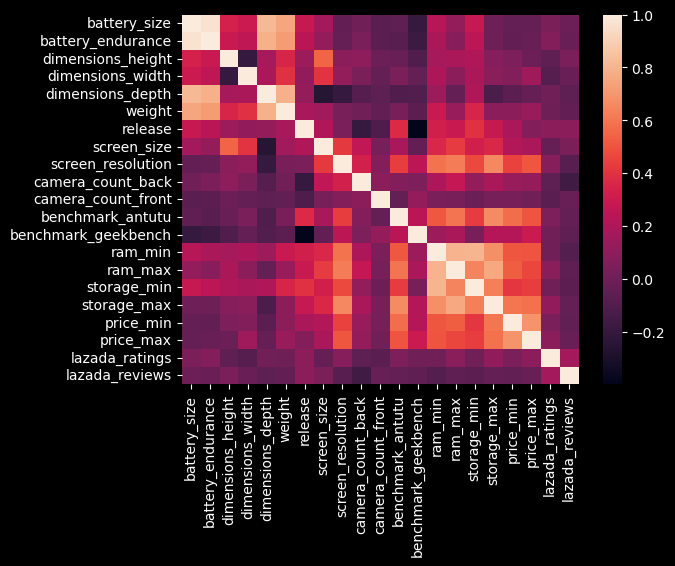

In [448]:
# show more plot
sns.heatmap(clean_data.corr(numeric_only=True))
plt.show()


In [15]:
# show more plot, comparing the values show the distribution of the data
for i in clean_data.columns:
    if clean_data[i].dtype == 'float64':
        sns.histplot(clean_data[i])
        plt.show()
        

NameError: name 'sns' is not defined

<Axes: xlabel='battery_size', ylabel='battery_endurance'>

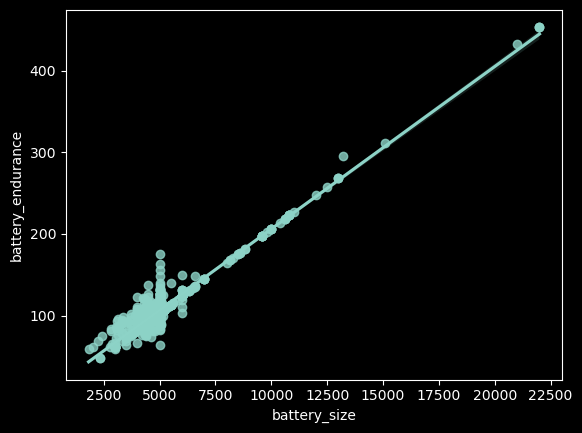

In [454]:
# corellation of categorical data in plot
sns.regplot(x='battery_size', y='battery_endurance', data=clean_data)

<Axes: xlabel='screen_size', ylabel='screen_resolution'>

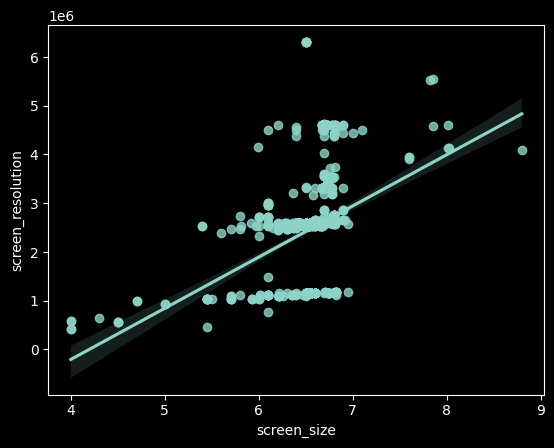

In [455]:
sns.regplot(x='screen_size', y='screen_resolution', data=clean_data)

<Axes: xlabel='price_min', ylabel='price_max'>

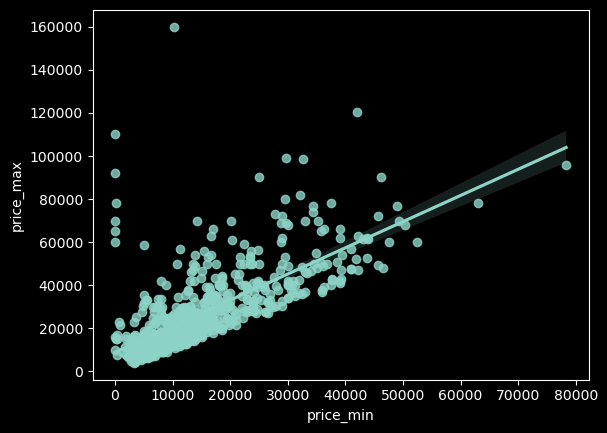

In [456]:
sns.regplot(x='price_min', y='price_max', data=clean_data)

<Axes: xlabel='ram_min', ylabel='ram_max'>

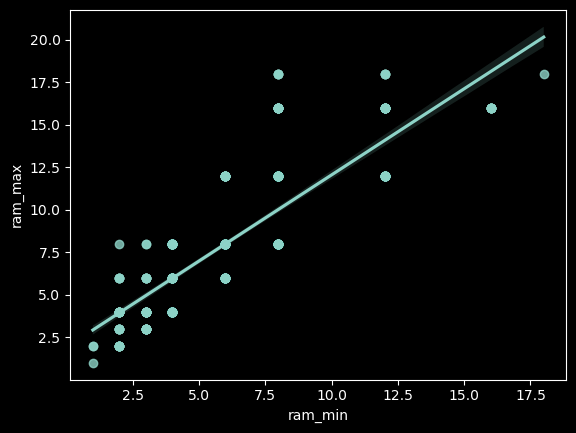

In [457]:
sns.regplot(x='ram_min', y='ram_max', data=clean_data)

<Axes: xlabel='storage_min', ylabel='storage_max'>

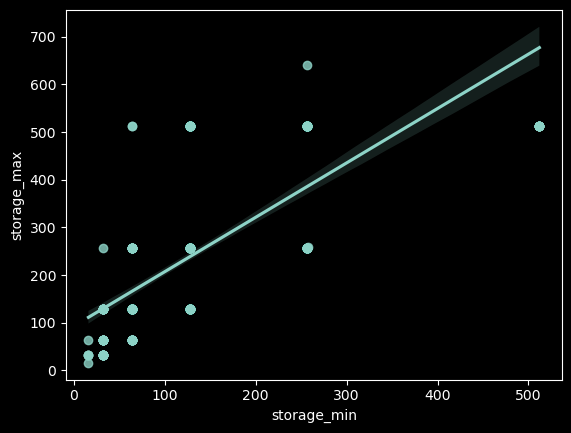

In [458]:
sns.regplot(x='storage_min', y='storage_max', data=clean_data)

<Axes: xlabel='lazada_ratings', ylabel='lazada_reviews'>

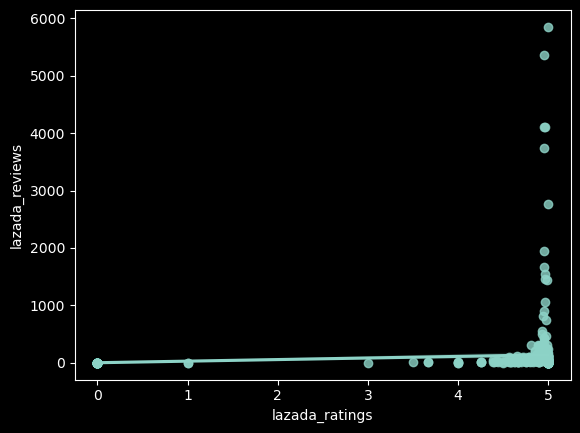

In [459]:
sns.regplot(x='lazada_ratings', y='lazada_reviews', data=clean_data)

<Axes: xlabel='price_min', ylabel='lazada_ratings'>

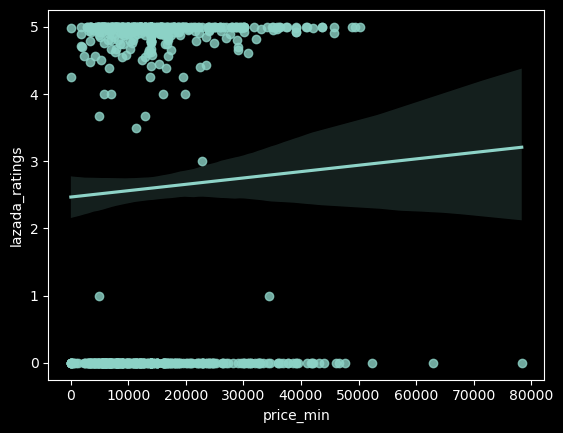

In [460]:
sns.regplot(x='price_min', y='lazada_ratings', data=clean_data)

<Axes: xlabel='price_max', ylabel='benchmark_antutu'>

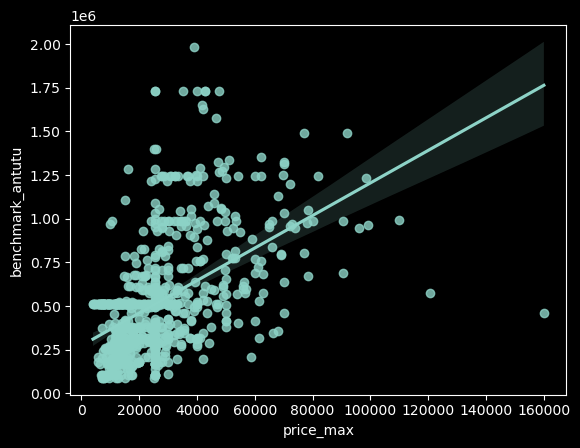

In [461]:
sns.regplot(x='price_max', y='benchmark_antutu', data=clean_data)

<Axes: xlabel='brand', ylabel='price_min'>

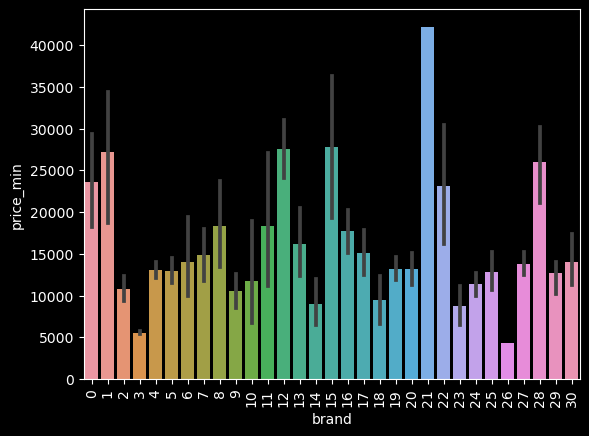

In [466]:
plt.xticks(rotation=90)
sns.barplot(x='brand', y='price_min', data=clean_data)

<Axes: xlabel='brand', ylabel='lazada_ratings'>

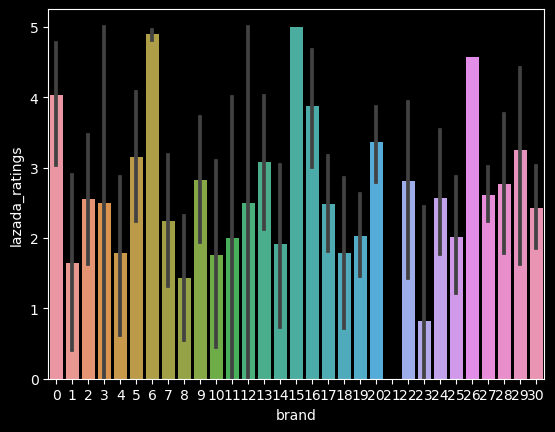

In [465]:
sns.barplot(x=clean_data['brand'], y=clean_data['lazada_ratings'])

In [ ]:
# new clean the data to store in dataframe


clean_data = pd.DataFrame()

# add rows as 'phone name key' to the dataframe and column as the 'os'
clean_data = pd.DataFrame(
    index=latest_phones_combined_flat.keys(), 
    columns=[
        'brand',
        'colors',
        'model',
        'battery_size',
        'battery_endurance',
        'dimensions_height',
        'dimensions_width',
        'dimensions_depth',
        'weight',
        'os',
        'release',
        'screen_size',
        'screen_resolution',
        'screen_type',
        'camera_count_back',
        'camera_count_front',
        'camera_list_resolution_back',
        'camera_list_resolution_front',
        'camera_resolution_back_recording',
        'camera_resolution_front_recording',
        'chipset',
        'benchmark_antutu',
        'benchmark_geekbench',
        'gpu',
        'ram_min',
        'ram_max',
        'storage_min',
        'storage_max',
        'storage_type',
        'price_min',
        'price_max',
        'lazada_ratings',
        'lazada_reviews',
        'build_material',
        'has_wifi',
        'has_bluetooth',
        'has_cardslot',
        'details'
    ])

x = []


# set column 1 header as 'phone'
clean_data.index.name = 'phone'


# add brand
clean_data['brand'] = [latest_phones_combined_flat[p]['brand'] for p in latest_phones_combined_flat]

# add model
clean_data['model'] = [latest_phones_combined_flat[p]['phone_name'] for p in latest_phones_combined_flat]

# add colors
clean_data['colors'] = [latest_phones_combined_flat[p]['specifications']['Misc']['Colors'][0].replace(', ', '|') if latest_phones_combined_flat[p]['specifications']['Misc'].get('Colors') else 'Unknown' for p in latest_phones_combined_flat]

# add battery size
find_battery = re.compile(r"(\d+) mAh", re.IGNORECASE)
# get average battery size
average_battery_size = np.mean([float(find_battery.findall(latest_phones_combined_flat[p]['specifications']['Battery']['Type'][0])[0]) for p in latest_phones_combined_flat if latest_phones_combined_flat[p]['specifications']['Battery'].get('Type') ])
clean_data['battery_size'] = [
    int(
        find_battery.findall(latest_phones_combined_flat[p]['specifications']['Battery']['Type'][0])[0])
        if 
            latest_phones_combined_flat[p]['specifications']['Battery'].get('Type') 
        else 
            np.nan 
        for p in latest_phones_combined_flat]


# add battery endurance
find_b_endurance = re.compile(r"(\d+)h", re.IGNORECASE)
# get average battery endurance
average_battery_endurance = np.mean([float(find_b_endurance.findall(latest_phones_combined_flat[p]['specifications']['Tests']['Battery (old)'][0])[0]) for p in latest_phones_combined_flat  if latest_phones_combined_flat[p]['specifications'].get('Tests') and latest_phones_combined_flat[p]['specifications']['Tests'].get('Battery (old)') ])
clean_data['battery_endurance'] = [
    float(
        find_b_endurance.findall(latest_phones_combined_flat[p]['specifications']['Tests']['Battery (old)'][0])[0]) 
        if 
            latest_phones_combined_flat[p]['specifications'].get('Tests') and latest_phones_combined_flat[p]['specifications']['Tests'].get('Battery (old)')  
        else 
            (average_battery_endurance/average_battery_size)*float(find_battery.findall(latest_phones_combined_flat[p]['specifications']['Battery']['Type'][0])[0])
        for p in latest_phones_combined_flat]

# add dimensions
find_dimensions = re.compile(r"(\d+(?:\.\d*)?)", re.IGNORECASE)
clean_data[['dimensions_height', 'dimensions_width', 'dimensions_depth']] = [
    x[:3]
    if 
        latest_phones_combined_flat[p]['specifications']['Body'].get('Dimensions') and len(x := find_dimensions.findall(latest_phones_combined_flat[p]['specifications']['Body']['Dimensions'][0]))
    else 
        [np.nan, np.nan, np.nan] 
    for p in latest_phones_combined_flat]

# add weight
find_weight = re.compile(r"(\d+\.?\d+) g", re.IGNORECASE)
clean_data['weight'] = [
    float(x[0])
    if 
        latest_phones_combined_flat[p]['specifications']['Body'].get('Weight') and (x := find_weight.findall(latest_phones_combined_flat[p]['specifications']['Body']['Weight'][0])) 
    else 
        np.nan 
    for p in latest_phones_combined_flat]

# supply missing values
clean_data['weight'] = clean_data['weight'].fillna(clean_data['weight'].mean())

# add os
find = re.compile(r"Android|iOS|Windows|Blackberry|Symbian|Bada|Tizen|KaiOS|Feature phone|HarmonyOS|EMUI", re.IGNORECASE)
clean_data['os'] = ['Android' if (r := find.match(latest_phones_combined_flat[p]['os'])[0]).lower() == 'emui' else r for p in latest_phones_combined_flat]

# add release
clean_data['release'] = [latest_phones_combined_flat[p]['specifications']['Launch']['Announced'][0] if latest_phones_combined_flat[p]['specifications']['Launch'].get('Announced') else None for p in latest_phones_combined_flat]

# add screen size
find_screen_size = re.compile(r"(\d+\.?\d+) inches", re.IGNORECASE)
clean_data['screen_size'] = [
    float(x[0]) 
    if 
        latest_phones_combined_flat[p]['specifications']['Display'].get('Size') and (x := find_screen_size.findall(latest_phones_combined_flat[p]['specifications']['Display']['Size'][0])) 
    else 
        np.nan 
    for p in latest_phones_combined_flat]

# add screen resolution
find_screen_resolution = re.compile(r"(\d+) x (\d+)", re.IGNORECASE)

clean_data['screen_resolution'] = [
    float(x[0][0]) * float(x[0][1])
    if 
        latest_phones_combined_flat[p]['specifications']['Display'].get('Resolution') and len(x := find_screen_resolution.findall(latest_phones_combined_flat[p]['specifications']['Display']['Resolution'][0])) == 1
    else 
        np.nan 
    for p in latest_phones_combined_flat]

# add screen type
find_screen_type = re.compile(r"(\b(?:LCD|OLED|AMOLED|IPS|TFT|P-OLED|Super AMOLED|Super Retina XDR OLED)\b)", re.IGNORECASE)
clean_data['screen_type'] = [
    x[0]
    if 
        latest_phones_combined_flat[p]['specifications']['Display'].get('Type') and (x := find_screen_type.findall(latest_phones_combined_flat[p]['specifications']['Display']['Type'][0])) 
    else 
        'Unknown' 
    for p in latest_phones_combined_flat]

find_camera_resolution = re.compile(r"(\d+(?:\.\d*)?) MP", re.IGNORECASE)
# add camera count, if Main Camera has key 'Quad' or 'Triple' or 'Dual' or 'Single
clean_data[['camera_count_back', 'camera_list_resolution_back']] = [
    (  
        4, 
        '|'.join(find_camera_resolution.findall(x['Quad'][0])[:4])
     ) if (x := latest_phones_combined_flat[p]['specifications'].get('Main Camera')) and 'Quad' in x 
    else (
        3,
        '|'.join(find_camera_resolution.findall(x['Triple'][0])[:3])
        ) if x and 'Triple' in x 
    else (
        2,
        '|'.join(find_camera_resolution.findall(x['Dual'][0])[:2])
        ) if x and 'Dual' in x 
    else (
        1,
        '|'.join(find_camera_resolution.findall(x['Single'][0])[:1])
          ) if x and 'Single' in x 
    else (
        0,
        '0'
        ) for p in latest_phones_combined_flat]

# add camera count, if Front Camera has key 'Quad' or 'Triple' or 'Dual' or 'Single
clean_data[['camera_count_front', 'camera_list_resolution_front']] = [
    (  
        4, 
        '|'.join(find_camera_resolution.findall(x['Quad'][0])[:4])
     ) if (x := latest_phones_combined_flat[p]['specifications'].get('Selfie camera')) and 'Quad' in x 
    else (
        3,
        '|'.join(find_camera_resolution.findall(x['Triple'][0])[:3])
        ) if x and 'Triple' in x 
    else (
        2,
        '|'.join(find_camera_resolution.findall(x['Dual'][0])[:2])
        ) if x and 'Dual' in x 
    else (
        1,
        '|'.join(find_camera_resolution.findall(x['Single'][0]))
          ) if x and 'Single' in x 
    else (
        0,
        '0'
        ) for p in latest_phones_combined_flat]

# add chipset
clean_data['chipset'] = [
    x[0].split('(')[0].strip() 
    if 
        latest_phones_combined_flat[p]['specifications'].get('Platform') and 
        (x := latest_phones_combined_flat[p]['specifications']['Platform'].get('Chipset'))
    else 
        None 
    for p in latest_phones_combined_flat]


# add benchmark antutu
find_benchmark_antutu = re.compile(r"AnTuTu: (\d+)", re.IGNORECASE)
clean_data['benchmark_antutu'] = [
    int(x[0]) 
    if 
        latest_phones_combined_flat[p]['specifications'].get('Tests') and 
        latest_phones_combined_flat[p]['specifications']['Tests'].get('Performance') and
        (x := find_benchmark_antutu.findall(latest_phones_combined_flat[p]['specifications']['Tests']['Performance'][0]))
    else 
        np.nan 
    for p in latest_phones_combined_flat]


# Group the similar chipsets. Get the average of the benchmark, combining the similar chipsets
for chipset in clean_data['chipset'].value_counts().index:
    # fill only the null values
    clean_data.loc[(clean_data['chipset'] == chipset) , 'benchmark_antutu'] = clean_data.loc[(clean_data['chipset'] == chipset), 'benchmark_antutu'].fillna(clean_data.loc[clean_data['chipset'] == chipset, 'benchmark_antutu'].mean())

# fill the missing values
clean_data['benchmark_antutu'] = clean_data['benchmark_antutu'].fillna(clean_data['benchmark_antutu'].mean()).astype(int)


# add benchmark geekbench
find_benchmark_geekbench = re.compile(r"GeekBench: (\d+)", re.IGNORECASE)
clean_data['benchmark_geekbench'] = [
    int(x[0]) 
    if 
        latest_phones_combined_flat[p]['specifications'].get('Tests') and 
        latest_phones_combined_flat[p]['specifications']['Tests'].get('Performance') and
        (x := find_benchmark_geekbench.findall(latest_phones_combined_flat[p]['specifications']['Tests']['Performance'][0]))
    else 
        np.nan 
    for p in latest_phones_combined_flat]

# Group the similar chipsets. Get the average of the benchmark, combining the similar chipsets
for chipset in clean_data['chipset'].value_counts().index:
    # fill only the null values
    clean_data.loc[(clean_data['chipset'] == chipset) , 'benchmark_geekbench'] = clean_data.loc[(clean_data['chipset'] == chipset), 'benchmark_geekbench'].fillna(clean_data.loc[clean_data['chipset'] == chipset, 'benchmark_geekbench'].mean())

# fill the missing values
clean_data['benchmark_geekbench'] = clean_data['benchmark_geekbench'].fillna(clean_data['benchmark_geekbench'].mean()).astype(int)

# add gpu
clean_data['gpu'] = [
    x[0].split('(')[0].strip() 
    if 
        latest_phones_combined_flat[p]['specifications'].get('Platform') and 
        (x := latest_phones_combined_flat[p]['specifications']['Platform'].get('GPU'))
    else 
        None 
    for p in latest_phones_combined_flat]

# supply missing values from the non missing gpu, get the data from the same chipset
for gpu in clean_data[~clean_data['gpu'].isnull()]['gpu'].value_counts().index:
    # fill only the null values
    clean_data.loc[(clean_data['gpu'] == gpu) , 'chipset'] = clean_data.loc[(clean_data['gpu'] == gpu), 'chipset'].fillna(clean_data.loc[clean_data['gpu'] == gpu, 'chipset'].mode()[0])


# add values for the min and max of ram and storage
find_ram = re.compile(r"(\d+)GB (\d+)GB RAM", re.IGNORECASE)
clean_data[['storage_min', 'storage_max', 'ram_min', 'ram_max']] = [
    (  
        min([tuple(int(x) for x in tup) for tup in zip(*x)][0]),
        max([tuple(int(x) for x in tup) for tup in zip(*x)][0]),
        min([tuple(int(x) for x in tup) for tup in zip(*x)][1]),
        max([tuple(int(x) for x in tup) for tup in zip(*x)][1])
     ) if (x := find_ram.findall(latest_phones_combined_flat[p]['specifications']['Memory']['Internal'][0])) 
    else (
        np.nan,
        np.nan,
        np.nan,
        np.nan
        ) for p in latest_phones_combined_flat]

# add storage type
find_storage_type = re.compile(r"(\b(?:eMMC|UFS|NVMe)\b)", re.IGNORECASE)
clean_data['storage_type'] = [
    x[0]
    if 
        latest_phones_combined_flat[p]['specifications']['Memory'].get('Other') and (x := find_storage_type.findall(latest_phones_combined_flat[p]['specifications']['Memory']['Other'][0])) 
    else 
        None
    for p in latest_phones_combined_flat]

# supply missing values
clean_data['storage_type'] = clean_data['storage_type'].fillna(clean_data['storage_type'].mode()[0])

# add lazada ratings
clean_data['lazada_ratings'] = [
    (latest_phones_combined_flat[p]['Lazada']['Ratings'] if x['Ratings'] != '' else 0)
    if (x := latest_phones_combined_flat[p].get('Lazada')) else 0 
    for p in latest_phones_combined_flat]

# add lazada reviews
clean_data['lazada_reviews'] = [
    (latest_phones_combined_flat[p]['Lazada']['Reviews'] if x['Reviews'] != '' else 0)
    if (x := latest_phones_combined_flat[p].get('Lazada')) else 0 
    for p in latest_phones_combined_flat]

# add build material
find_build_material = re.compile(r"(\b(?:glass|aluminum|plastic|titanium|ceramic|stainless steel|carbon fiber)\b)", re.IGNORECASE)
clean_data['build_material'] = [
    '|'.join(x)
    if 
        latest_phones_combined_flat[p]['specifications']['Body'].get('Build') and (x := find_build_material.findall(latest_phones_combined_flat[p]['specifications']['Body']['Build'][0])) 
    else 
        None 
    for p in latest_phones_combined_flat]

# fill the missing values
clean_data['build_material'] = clean_data['build_material'].fillna(clean_data['build_material'].mode()[0])

# euro to php
def euro_to_php(euro):
    if euro is None or euro == '':
        return None
    return float(euro) * 60.25

# dollar to php
def dollar_to_php(dollar):
    if dollar is None or dollar == '':
        return None
    return float(dollar) * 55.90


# add min and max price
find_price = re.compile(r"(\d+(?:\.\d*)?) EUR|\$\u2009(\d+(?:\.\d+)?)", re.IGNORECASE)

clean_data[['price_min', 'price_max']] = [
        [min(y := [
            euro_to_php(x[0][0]) or dollar_to_php(x[0][1]), 
            float(latest_phones_combined_flat[p]['Lazada']['Price']),
            float(latest_phones_combined_flat[p]['Lazada']['Original Price'])],
            ),
        max(y)]
    if 
        latest_phones_combined_flat[p]['specifications']['Misc'].get('Price') and (x:= find_price.findall(latest_phones_combined_flat[p]['specifications']['Misc']['Price'][0]))
    else
    
        (np.nan, np.nan)
    for p in latest_phones_combined_flat]

# supply missing values
clean_data['price_min'] = clean_data['price_min'].fillna(clean_data['price_min'].mean())
clean_data['price_max'] = clean_data['price_max'].fillna(clean_data['price_max'].mean())

# add camera resolution back recording
find_camera_resolution_back_recording = re.compile(r"(\d+)fps", re.IGNORECASE)

# add camera resolution front recording
find_camera_resolution_recording = re.compile(r"((?:8K|4K|1080p|720p).*.fps|4K|1080p|720p)", re.IGNORECASE)

ll = []
for p in latest_phones_combined_flat:
    if latest_phones_combined_flat[p]['specifications'].get('Main Camera') and latest_phones_combined_flat[p]['specifications']['Main Camera'].get('Video'):
        o = []
        for i in latest_phones_combined_flat[p]['specifications']['Main Camera']['Video'][0].split(','):
            if (x := find_camera_resolution_recording.findall(i)):
                o.append(x[0])
            elif i.lower().find('yes') != -1:
                o.append('1080p@30fps')

        if o:
            ll.append('|'.join(o))
        else:
            ll.append(None)
    else:
        ll.append(None)
clean_data['camera_resolution_back_recording'] = ll

# add camera resolution front recording
ll = []
for p in latest_phones_combined_flat:
    if latest_phones_combined_flat[p]['specifications'].get('Selfie camera') and latest_phones_combined_flat[p]['specifications']['Selfie camera'].get('Video'):
        o = []
        for i in latest_phones_combined_flat[p]['specifications']['Selfie camera']['Video'][0].split(','):
            if (x := find_camera_resolution_recording.findall(i)):
                o.append(x[0])
            elif i.lower().find('yes') != -1:
                o.append('1080p@30fps')

        if o:
            ll.append('|'.join(o))
        else:
            ll.append(None)
    else:
        ll.append(None)
clean_data['camera_resolution_front_recording'] = ll

# add has wireless
find_wifi = re.compile(r".*\|.*", re.IGNORECASE)
ll = []
for p in latest_phones_combined_flat:
    if latest_phones_combined_flat[p]['specifications'].get('Comms') and latest_phones_combined_flat[p]['specifications']['Comms'].get('WLAN'):
        done = False
        if (x := latest_phones_combined_flat[p]['specifications']['Comms']['WLAN'][0].split(',')[0]).lower() != 'yes':
            for i in x.split():
                if find_wifi.match(i := i.replace('/', '|')):
                    ll.append(i)
                    done = True
                    break

            if not done:
                ll.append(None)
        else:
            ll.append(None)
    else:
        ll.append('No')
clean_data['has_wifi'] = ll

# supply missing values
clean_data['has_wifi'] = clean_data['has_wifi'].fillna(clean_data['has_wifi'].mode()[0])

# add has bluetooth
ll = []
for p in latest_phones_combined_flat:
    if latest_phones_combined_flat[p]['specifications'].get('Comms') and latest_phones_combined_flat[p]['specifications']['Comms'].get('Bluetooth'):
        if (x:=latest_phones_combined_flat[p]['specifications']['Comms']['Bluetooth'][0].split(',')[0]).lower() != 'no' and x != 'yes':
            ll.append(x)
        elif x.lower() == 'yes':
            ll.append(None)
        else:
            ll.append('No')
    else:
        ll.append('No')
clean_data['has_bluetooth'] = ll

# supply missing values
clean_data['has_bluetooth'] = clean_data['has_bluetooth'].fillna(clean_data['has_bluetooth'].mode()[0])

# add has cardslot
clean_data['has_cardslot'] = ['Yes' if (x := latest_phones_combined_flat[p]['specifications']['Memory'].get('Card slot')) and x[0].lower() != 'no' else 'No' for p in latest_phones_combined_flat]

# add details, (this is the combinatin of all the data)
def _removeNonAscii(s):
    return "".join(i for i in s if  ord(i)<128)

# flatten the json data int string
ll = []
for p in latest_phones_combined_flat:
    lls = ''
    for k in latest_phones_combined_flat[p]:
        kl = k.lower()
        if kl == 'lazada':
            lls += latest_phones_combined_flat[p][k]['URL'] + '|'
        if kl in ('brand', 'dimension', 'os', 'phone_name', 'release_date', 'storage', 'model'):
            lls += _removeNonAscii(latest_phones_combined_flat[p][k]) + '|'
        if kl == 'specifications':
            for s in latest_phones_combined_flat[p][k]:
                sl = s.lower()
                if sl in ('battery', 'body', 'comms', 'display', 'memory', 'platform', 'selfie camera', 'main camera', 'launch', 'tests', 'misc'):
                    for ss in latest_phones_combined_flat[p][k][s]:
                        ssl = ss.lower()
                        if ssl in ('dimensions', 'weight', 'build', 'size', 'resolution', 'internal', 'type', 'battery (old)' ):
                            continue
                        elif ssl in ('bluetooth', 'nfc', 'radio', '5g bands', '4g bands', '3g bands', '2g bands', 'speed', 'gprs', '3.5mm jack', 'loudspeaker', ):
                            lls += ss + '|'
                        else: 
                            lls += _removeNonAscii(latest_phones_combined_flat[p][k][s][ss][0]) + '|'

    # get all the data in clean_data and add it to the details
    for c in clean_data.columns:
        lls += '|'.join([str(x).replace(' ', '') for x in clean_data.loc[p].loc[clean_data.columns != 'details']])

    lls += '|'.join([str(x).replace(' ', '') for x in clean_data.loc[p].loc[clean_data.columns != 'details']]) 

    ll.append(lls)

clean_data['details'] = ll
        



# remove the data with null values
clean_data = clean_data.dropna()

# remove the data with '' values
clean_data = clean_data.replace('', np.nan)

# supply missing values
clean_data['camera_list_resolution_front'] = clean_data['camera_list_resolution_front'].fillna( clean_data['camera_list_resolution_front'].mode()[0])




# save the data
clean_data.to_csv('clean_phone_data.csv')

print(clean_data.shape, clean_data.isna().sum().sum())
clean_data.head()


In [16]:
import pandas as pd
from sklearn import linear_model
from sklearn.ensemble import VotingClassifier
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

Y_COLUMN = "author"
TEXT_COLUMN = "text"

unigram_log_pipe = Pipeline([
    ('cv', CountVectorizer()),
    ('logreg', linear_model.LogisticRegression())
])

ngram_pipe = Pipeline([
    ('cv', CountVectorizer(ngram_range=(1, 2))),
    ('mnb', MultinomialNB())
])

tfidf_pipe = Pipeline([
    ('tfidf', TfidfVectorizer(min_df=3, max_features=None,
                              strip_accents='unicode', analyzer='word', token_pattern=r'\w{1,}',
                              ngram_range=(1, 3), use_idf=1, smooth_idf=1, sublinear_tf=1,
                              stop_words='english')),
    ('mnb', MultinomialNB())
])

classifiers = [
    ("ngram", ngram_pipe),
    ("unigram", unigram_log_pipe),
    ("tfidf", tfidf_pipe),
]

mixed_pipe = Pipeline([
    ("voting", VotingClassifier(classifiers, voting="soft"))
])


from sklearn.model_selection import GridSearchCV


def combinations_on_off(num_classifiers):
    return [[int(x) for x in list("{0:0b}".format(i).zfill(num_classifiers))]
            for i in range(1, 2 ** num_classifiers)]


param_grid = dict(
    voting__weights=combinations_on_off(len(classifiers))
)

X = clean_data['details']
y = clean_data[['brand', 'model']]

grid_search = GridSearchCV(mixed_pipe, param_grid=param_grid, n_jobs=-1, verbose=10, scoring="neg_log_loss")

grid_search.fit(X, y)

cv_results = grid_search.cv_results_


Fitting 5 folds for each of 7 candidates, totalling 35 fits


ValueError: 
All the 35 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
21 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\RenzCute\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\RenzCute\anaconda3\Lib\site-packages\sklearn\pipeline.py", line 405, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "c:\Users\RenzCute\anaconda3\Lib\site-packages\sklearn\ensemble\_voting.py", line 342, in fit
    self.le_ = LabelEncoder().fit(y)
               ^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\RenzCute\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py", line 99, in fit
    y = column_or_1d(y, warn=True)
        ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\RenzCute\anaconda3\Lib\site-packages\sklearn\utils\validation.py", line 1202, in column_or_1d
    raise ValueError(
ValueError: y should be a 1d array, got an array of shape (658, 2) instead.

--------------------------------------------------------------------------------
14 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\RenzCute\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\RenzCute\anaconda3\Lib\site-packages\sklearn\pipeline.py", line 405, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "c:\Users\RenzCute\anaconda3\Lib\site-packages\sklearn\ensemble\_voting.py", line 342, in fit
    self.le_ = LabelEncoder().fit(y)
               ^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\RenzCute\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py", line 99, in fit
    y = column_or_1d(y, warn=True)
        ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\RenzCute\anaconda3\Lib\site-packages\sklearn\utils\validation.py", line 1202, in column_or_1d
    raise ValueError(
ValueError: y should be a 1d array, got an array of shape (659, 2) instead.


In [2]:

for mean_score, params in zip(cv_results["mean_test_score"], cv_results["params"]):
    print(params, mean_score)

print("Best score: %0.3f" % grid_search.best_score_)
print("Best parameters set:")
best_parameters = grid_search.best_estimator_.get_params()
for param_name in sorted(param_grid.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))

NameError: name 'tfidf_pipe' is not defined

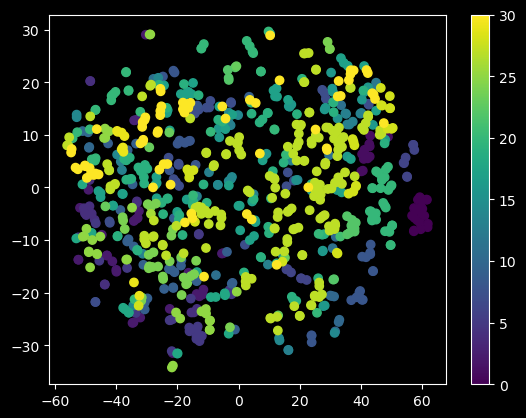

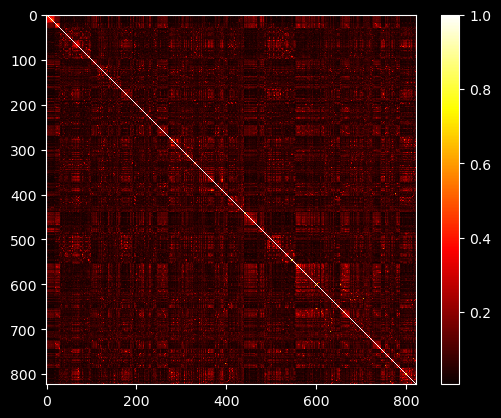

In [472]:
# visualize knn
from sklearn.manifold import TSNE

# perform Tf-idf on the data
tfidf = TfidfVectorizer()
X_tfidf = tfidf.fit_transform(clean_data['details'])

# perform tsne on the data
tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(X_tfidf.toarray())

# plot the data
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=clean_data['brand'].astype('category').cat.codes, cmap="viridis")
plt.colorbar()
plt.show()




In [17]:

import pandas as pd

# open the file
with open('clean_phone_data.csv', 'r') as f:
    clean_data = pd.read_csv(f, index_col=0)

clean_data.head()

,brand,colors,model,battery_size,battery_endurance,weight,os,release,screen_size,screen_resolution,...,storage_type,price_min,price_max,lazada_ratings,lazada_reviews,build_material,has_wifi,has_bluetooth,has_cardslot,details
phone,,,,,,,,,,,,,,,,,,,,,
apple_iphone_11-9848,Apple,Black|Green|Yellow|Purple|Red|White,iPhone 11,3110,94.0,194.0,iOS,2019,6.1,1483776.0,...,NVMe,12745.200,37990.0,4.939130,805,Glass|glass|glass|glass|aluminum,a|b|g|n|ac|6,5.0,No,//www.lazada.com.ph/products/apple-iphone-11-l...
apple_iphone_11_pro-9847,Apple,Matte Space Gray|Matte Silver|Matte Gold|Matte...,iPhone 11 Pro,3046,86.0,188.0,iOS,2019,5.8,2740500.0,...,NVMe,16155.100,34990.0,0.000000,0,Glass|glass|glass|glass|stainless steel,a|b|g|n|ac|6,5.0,No,//www.lazada.com.ph/products/apple-iphone-11-p...
apple_iphone_11_pro_max-9846,Apple,Matte Space Gray|Matte Silver|Matte Gold|Matte...,iPhone 11 Pro Max,3969,102.0,226.0,iOS,2019,6.5,3338496.0,...,NVMe,18600.725,43460.0,0.000000,0,Glass|glass|glass|glass|stainless steel,a|b|g|n|ac|6,5.0,No,//www.lazada.com.ph/products/11-promax-64gbbra...
apple_iphone_12-10509,Apple,Black|White|Red|Green|Blue|Purple,iPhone 12,2815,84.0,164.0,iOS,2020,6.1,2962440.0,...,NVMe,13886.678,53990.0,4.924797,492,Glass|glass|glass|glass|aluminum,a|b|g|n|ac|6,5.0,No,//www.lazada.com.ph/products/apple-iphone-12-i...
apple_iphone_12_mini-10510,Apple,Black|White|Red|Green|Blue|Purple,iPhone 12 mini,2227,69.0,135.0,iOS,2020,5.4,2527200.0,...,NVMe,13807.300,25990.0,5.000000,22,Glass|glass|glass|glass|aluminum,a|b|g|n|ac|6,5.0,No,//www.lazada.com.ph/products/apple-iphone-12-m...


In [479]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import GridSearchCV

# Define the parameter grid
param_grid = {
    'min_df': [-1, 1, 2, 3],
    'max_features': [None, 1000, 5000, 10000],
    'ngram_range': [(1, 1), (1, 2), (1, 3)],
    'use_idf': [True, False],
    'smooth_idf': [True, False],
    'sublinear_tf': [True, False],
    'stop_words': ['english'],
    'analyzer': ['word', 'char', 'char_wb'],
    
}

# Create the TfidfVectorizer
tfidf = TfidfVectorizer()

# Create the GridSearchCV object
grid_search = GridSearchCV(tfidf, param_grid, cv=10, n_jobs=-1, verbose=1, scoring='neg_mean_squared_error')

# Fit the GridSearchCV object to the data
grid_search.fit(X, y)

# Get the best parameters and score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

# Print the best parameters and score
print("Best parameters:", best_params)
print("Best score:", best_score)


Fitting 10 folds for each of 1152 candidates, totalling 11520 fits


c:\Users\RenzCute\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:425: FitFailedWarning: 
4800 fits failed out of a total of 11520.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
2880 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\RenzCute\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\RenzCute\anaconda3\Lib\site-packages\sklearn\base.py", line 1144, in wrapper
    estimator._validate_params()
  File "c:\Users\RenzCute\anaconda3\Lib\site-packages\sklearn\base.py", line 637, in _validate_params
    validate_parameter_constraints(
  File "c:\Users\RenzCute\anacon

InvalidParameterError: The 'min_df' parameter of TfidfVectorizer must be a float in the range [0.0, 1.0] or an int in the range [1, inf). Got -1 instead.

In [66]:
# use confusion matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LogisticRegression


tfidf = TfidfVectorizer(stop_words='english')
clean_data_details = tfidf.fit_transform(clean_data['details'])

# remove the details
clean_data = clean_data.drop('details', axis=1)



## COSINE SIMILARITY

In [60]:
from sklearn.metrics.pairwise import cosine_similarity
# use tfidf for the non numerical data
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse import hstack
import numpy as np


# combine the non numerical data into another dataframe
# concatenate the strings


# remove non utf-8 characters
def recommend(
        specs,
        n=10,
        **kwargs):
    
    tfidf = TfidfVectorizer(stop_words='english')
    X = tfidf.fit_transform(clean_data['details'].str.replace(r'[^a-zA-Z0-9_]', ' ', regex=True))
    # Transform the input specs using TF-IDF vectorizer
    specs_vectorized = tfidf.transform([specs])
    
    for k, v in kwargs.items():
        if k in clean_data.columns:
            X = hstack((X, tfidf.fit_transform(clean_data[k].astype(str).str.replace(r'[^a-zA-Z0-9_]', ' ', regex=True))))
            specs_vectorized = hstack((specs_vectorized, tfidf.transform([v])))

    
    # Calculate similarity scores between input specs and all phones
    sim_scores = cosine_similarity(specs_vectorized, X)

    # print mean absolute error of the results
    

    # Return recommended phones
    return clean_data.iloc[sim_scores.argsort()[0][::-1][:n]]




# get the recommended phone
recommend('', brand='samsung', price = '19000' )



,brand,colors,model,battery_size,battery_endurance,weight,os,release,screen_size,screen_resolution,...,lazada_ratings,lazada_reviews,build_material,has_wifi,has_bluetooth,has_cardslot,details,price,ram,storage
phone,,,,,,,,,,,,,,,,,,,,,
samsung_galaxy_a33_5g-11429,Samsung,Black|White|Blue|Peach,Galaxy A33 5G,5000,104.000000,186.0,Android,2022,6.4,2592000.0,...,0.000000,0,Glass|Glass|plastic|plastic,a|b|g|n|ac,5.1,Yes,//www.lazada.com.ph/products/samsung-galaxy-a3...,17519.4705,6.0,192.0
samsung_galaxy_a05s-12584,Samsung,Black|Silver|Light Green|Violet,Galaxy A05s,5000,103.074491,194.0,Android,2023,6.7,2592000.0,...,5.000000,12,Glass|plastic|plastic,a|b|g|n|ac,5.1,Yes,//www.lazada.com.ph/products/samsung-galaxy-a0...,8944.2615,5.0,96.0
samsung_galaxy_a20s-9852,Samsung,Black|Blue|Red|Green,Galaxy A20s,4000,82.459593,183.0,Android,2019,6.5,1123200.0,...,5.000000,1,Glass|plastic|plastic,b|g|n,4.2,Yes,//www.lazada.com.ph/products/samsung-galaxy-a2...,12030.7500,3.0,48.0
samsung_galaxy_a04-11817,Samsung,Black|Green|White|Copper,Galaxy A04,5000,103.074491,192.0,Android,2022,6.5,1152000.0,...,4.949008,353,Glass|plastic|plastic,a|b|g|n|ac,5.0,Yes,//www.lazada.com.ph/products/samsung-galaxy-a0...,7708.4115,5.5,80.0
samsung_galaxy_a73_5g-11257,Samsung,Gray|Mint|White,Galaxy A73 5G,5000,103.074491,181.0,Android,2022,6.7,2592000.0,...,0.000000,0,Glass|plastic|plastic,a|b|g|n|ac|6,5.0,Yes,//www.lazada.com.ph/products/samsung-galaxy-a7...,24777.5000,7.0,192.0
samsung_galaxy_a04s-11803,Samsung,Black|Green|White|Copper,Galaxy A04s,5000,114.000000,195.0,Android,2022,6.5,1152000.0,...,0.000000,0,Glass|plastic|plastic,a|b|g|n|ac,5.0,Yes,//www.lazada.com.ph/products/samsung-galaxy-a0...,7889.3750,3.5,80.0
samsung_galaxy_a05-12583,Samsung,Black|Silver|Light Green,Galaxy A05,5000,103.074491,195.0,Android,2023,6.7,1152000.0,...,0.000000,0,Glass|plastic|plastic,a|b|g|n|ac,5.3,Yes,//www.lazada.com.ph/products/samsung-galaxy-a0...,6757.7205,5.0,96.0
samsung_galaxy_a10s-9793,Samsung,Blue|Green|Red|Black,Galaxy A10s,4000,82.459593,168.0,Android,2019,6.2,1094400.0,...,5.000000,1,Glass|plastic|plastic,b|g|n,4.2,Yes,//www.lazada.com.ph/products/samsung-galaxy-a1...,8922.0000,2.5,32.0
samsung_galaxy_a13-11402,Samsung,Black|White|Peach|Blue,Galaxy A13,5000,114.000000,195.0,Android,2022,6.6,2600640.0,...,0.000000,0,Glass|Glass|plastic|plastic,a|b|g|n|ac,5.0,Yes,//www.lazada.com.ph/products/comworks-samsung-...,8735.6500,4.5,80.0


In [11]:
# get the f1 score of the algorithm
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

# Split the data into a training and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Create a logistic regression classifier
logreg = LogisticRegression()

# Fit the classifier to the training data
logreg.fit(X_train, y_train)

# Predict the labels of the test set
y_pred = logreg.predict(X_test)

# Compute the F1 score
f1 = f1_score(y_test, y_pred, average='micro')
print(f1)



ValueError: could not convert string to float: '//www.lazada.com.ph/products/original-nokia-72-4g-mobile-phone-626-4gb-ram-128gb-rom-dual-sim-cellphone-48mp-nfc-octa-core-android-smartphone-i3872898872.html|Nokia|180g, 8.3mm thickness|Android|7.2|Released 2019, September 23|10W wired|Single SIM (Nano-SIM) or Dual SIM (Nano-SIM, dual stand-by)|Bluetooth|NFC|GPS, GLONASS, GALILEO, BDS|Radio|USB Type-C 2.0, OTG|Wi-Fi 802.11 b/g/n/ac, dual-band, Wi-Fi Direct|Corning Gorilla Glass 3|2019|Available. Released 2019, September 23|Zeiss optics, LED flash, panorama, HDR|48 MP, f/1.8, (wide), 1/2.0", 0.8m, PDAF\n8 MP, f/2.2, 13mm (ultrawide), 1/4.0", 1.12m\n5 MP, f/2.4, (depth)|4K@30fps, 1080p@30fps (gyro-EIS)|microSDXC (dedicated slot)|eMMC 5.1|Cyan Green, Charcoal, Ice|TA-1193|About 240 EUR|1.15 W/kg (head)   0.90 W/kg (body)   |0.99 W/kg (head)   1.44 W/kg (body)   |Octa-core (4x2.2 GHz Kryo 260 Gold & 4x1.8 GHz Kryo 260 Silver)|Qualcomm SDM660 Snapdragon 660 (14 nm)|Adreno 512|Android 9.0 (Pie), upgradable to Android 11, Android One|Zeiss optics, HDR|20 MP, f/2.0, (wide), 1/3", 0.9m|1080p@30fps|\nNoise -93.0dB / Crosstalk -93.4dB|\nPhoto / Video|\nContrast ratio: 1342:1 (nominal)|Loudspeaker||\nAnTuTu: 139495 (v7), 164484 (v8)\nGeekBench: 5440 (v4.4), 1398 (v5.1)\nGFXBench: 8.1fps (ES 3.1 onscreen)|64GB/128GB storage, microSDXC|Nokia|CyanGreen|Charcoal|Ice|7.2|3500|69.0|159.9|75.2|8.3|180.0|Android|2019|6.3|2462400.0|IPS|3|1|48|8|5|20|4K@30fps|1080p@30fps|1080p@30fps|QualcommSDM660Snapdragon660|139495|5440|Adreno512|4.0|6.0|64.0|128.0|eMMC|8400.0|15800.0|0|0|Glass|Glass|glass|Glass|plastic|b|g|n|ac|5.0|YesNokia|CyanGreen|Charcoal|Ice|7.2|3500|69.0|159.9|75.2|8.3|180.0|Android|2019|6.3|2462400.0|IPS|3|1|48|8|5|20|4K@30fps|1080p@30fps|1080p@30fps|QualcommSDM660Snapdragon660|139495|5440|Adreno512|4.0|6.0|64.0|128.0|eMMC|8400.0|15800.0|0|0|Glass|Glass|glass|Glass|plastic|b|g|n|ac|5.0|YesNokia|CyanGreen|Charcoal|Ice|7.2|3500|69.0|159.9|75.2|8.3|180.0|Android|2019|6.3|2462400.0|IPS|3|1|48|8|5|20|4K@30fps|1080p@30fps|1080p@30fps|QualcommSDM660Snapdragon660|139495|5440|Adreno512|4.0|6.0|64.0|128.0|eMMC|8400.0|15800.0|0|0|Glass|Glass|glass|Glass|plastic|b|g|n|ac|5.0|YesNokia|CyanGreen|Charcoal|Ice|7.2|3500|69.0|159.9|75.2|8.3|180.0|Android|2019|6.3|2462400.0|IPS|3|1|48|8|5|20|4K@30fps|1080p@30fps|1080p@30fps|QualcommSDM660Snapdragon660|139495|5440|Adreno512|4.0|6.0|64.0|128.0|eMMC|8400.0|15800.0|0|0|Glass|Glass|glass|Glass|plastic|b|g|n|ac|5.0|YesNokia|CyanGreen|Charcoal|Ice|7.2|3500|69.0|159.9|75.2|8.3|180.0|Android|2019|6.3|2462400.0|IPS|3|1|48|8|5|20|4K@30fps|1080p@30fps|1080p@30fps|QualcommSDM660Snapdragon660|139495|5440|Adreno512|4.0|6.0|64.0|128.0|eMMC|8400.0|15800.0|0|0|Glass|Glass|glass|Glass|plastic|b|g|n|ac|5.0|YesNokia|CyanGreen|Charcoal|Ice|7.2|3500|69.0|159.9|75.2|8.3|180.0|Android|2019|6.3|2462400.0|IPS|3|1|48|8|5|20|4K@30fps|1080p@30fps|1080p@30fps|QualcommSDM660Snapdragon660|139495|5440|Adreno512|4.0|6.0|64.0|128.0|eMMC|8400.0|15800.0|0|0|Glass|Glass|glass|Glass|plastic|b|g|n|ac|5.0|YesNokia|CyanGreen|Charcoal|Ice|7.2|3500|69.0|159.9|75.2|8.3|180.0|Android|2019|6.3|2462400.0|IPS|3|1|48|8|5|20|4K@30fps|1080p@30fps|1080p@30fps|QualcommSDM660Snapdragon660|139495|5440|Adreno512|4.0|6.0|64.0|128.0|eMMC|8400.0|15800.0|0|0|Glass|Glass|glass|Glass|plastic|b|g|n|ac|5.0|YesNokia|CyanGreen|Charcoal|Ice|7.2|3500|69.0|159.9|75.2|8.3|180.0|Android|2019|6.3|2462400.0|IPS|3|1|48|8|5|20|4K@30fps|1080p@30fps|1080p@30fps|QualcommSDM660Snapdragon660|139495|5440|Adreno512|4.0|6.0|64.0|128.0|eMMC|8400.0|15800.0|0|0|Glass|Glass|glass|Glass|plastic|b|g|n|ac|5.0|YesNokia|CyanGreen|Charcoal|Ice|7.2|3500|69.0|159.9|75.2|8.3|180.0|Android|2019|6.3|2462400.0|IPS|3|1|48|8|5|20|4K@30fps|1080p@30fps|1080p@30fps|QualcommSDM660Snapdragon660|139495|5440|Adreno512|4.0|6.0|64.0|128.0|eMMC|8400.0|15800.0|0|0|Glass|Glass|glass|Glass|plastic|b|g|n|ac|5.0|YesNokia|CyanGreen|Charcoal|Ice|7.2|3500|69.0|159.9|75.2|8.3|180.0|Android|2019|6.3|2462400.0|IPS|3|1|48|8|5|20|4K@30fps|1080p@30fps|1080p@30fps|QualcommSDM660Snapdragon660|139495|5440|Adreno512|4.0|6.0|64.0|128.0|eMMC|8400.0|15800.0|0|0|Glass|Glass|glass|Glass|plastic|b|g|n|ac|5.0|YesNokia|CyanGreen|Charcoal|Ice|7.2|3500|69.0|159.9|75.2|8.3|180.0|Android|2019|6.3|2462400.0|IPS|3|1|48|8|5|20|4K@30fps|1080p@30fps|1080p@30fps|QualcommSDM660Snapdragon660|139495|5440|Adreno512|4.0|6.0|64.0|128.0|eMMC|8400.0|15800.0|0|0|Glass|Glass|glass|Glass|plastic|b|g|n|ac|5.0|YesNokia|CyanGreen|Charcoal|Ice|7.2|3500|69.0|159.9|75.2|8.3|180.0|Android|2019|6.3|2462400.0|IPS|3|1|48|8|5|20|4K@30fps|1080p@30fps|1080p@30fps|QualcommSDM660Snapdragon660|139495|5440|Adreno512|4.0|6.0|64.0|128.0|eMMC|8400.0|15800.0|0|0|Glass|Glass|glass|Glass|plastic|b|g|n|ac|5.0|YesNokia|CyanGreen|Charcoal|Ice|7.2|3500|69.0|159.9|75.2|8.3|180.0|Android|2019|6.3|2462400.0|IPS|3|1|48|8|5|20|4K@30fps|1080p@30fps|1080p@30fps|QualcommSDM660Snapdragon660|139495|5440|Adreno512|4.0|6.0|64.0|128.0|eMMC|8400.0|15800.0|0|0|Glass|Glass|glass|Glass|plastic|b|g|n|ac|5.0|YesNokia|CyanGreen|Charcoal|Ice|7.2|3500|69.0|159.9|75.2|8.3|180.0|Android|2019|6.3|2462400.0|IPS|3|1|48|8|5|20|4K@30fps|1080p@30fps|1080p@30fps|QualcommSDM660Snapdragon660|139495|5440|Adreno512|4.0|6.0|64.0|128.0|eMMC|8400.0|15800.0|0|0|Glass|Glass|glass|Glass|plastic|b|g|n|ac|5.0|YesNokia|CyanGreen|Charcoal|Ice|7.2|3500|69.0|159.9|75.2|8.3|180.0|Android|2019|6.3|2462400.0|IPS|3|1|48|8|5|20|4K@30fps|1080p@30fps|1080p@30fps|QualcommSDM660Snapdragon660|139495|5440|Adreno512|4.0|6.0|64.0|128.0|eMMC|8400.0|15800.0|0|0|Glass|Glass|glass|Glass|plastic|b|g|n|ac|5.0|YesNokia|CyanGreen|Charcoal|Ice|7.2|3500|69.0|159.9|75.2|8.3|180.0|Android|2019|6.3|2462400.0|IPS|3|1|48|8|5|20|4K@30fps|1080p@30fps|1080p@30fps|QualcommSDM660Snapdragon660|139495|5440|Adreno512|4.0|6.0|64.0|128.0|eMMC|8400.0|15800.0|0|0|Glass|Glass|glass|Glass|plastic|b|g|n|ac|5.0|YesNokia|CyanGreen|Charcoal|Ice|7.2|3500|69.0|159.9|75.2|8.3|180.0|Android|2019|6.3|2462400.0|IPS|3|1|48|8|5|20|4K@30fps|1080p@30fps|1080p@30fps|QualcommSDM660Snapdragon660|139495|5440|Adreno512|4.0|6.0|64.0|128.0|eMMC|8400.0|15800.0|0|0|Glass|Glass|glass|Glass|plastic|b|g|n|ac|5.0|YesNokia|CyanGreen|Charcoal|Ice|7.2|3500|69.0|159.9|75.2|8.3|180.0|Android|2019|6.3|2462400.0|IPS|3|1|48|8|5|20|4K@30fps|1080p@30fps|1080p@30fps|QualcommSDM660Snapdragon660|139495|5440|Adreno512|4.0|6.0|64.0|128.0|eMMC|8400.0|15800.0|0|0|Glass|Glass|glass|Glass|plastic|b|g|n|ac|5.0|YesNokia|CyanGreen|Charcoal|Ice|7.2|3500|69.0|159.9|75.2|8.3|180.0|Android|2019|6.3|2462400.0|IPS|3|1|48|8|5|20|4K@30fps|1080p@30fps|1080p@30fps|QualcommSDM660Snapdragon660|139495|5440|Adreno512|4.0|6.0|64.0|128.0|eMMC|8400.0|15800.0|0|0|Glass|Glass|glass|Glass|plastic|b|g|n|ac|5.0|YesNokia|CyanGreen|Charcoal|Ice|7.2|3500|69.0|159.9|75.2|8.3|180.0|Android|2019|6.3|2462400.0|IPS|3|1|48|8|5|20|4K@30fps|1080p@30fps|1080p@30fps|QualcommSDM660Snapdragon660|139495|5440|Adreno512|4.0|6.0|64.0|128.0|eMMC|8400.0|15800.0|0|0|Glass|Glass|glass|Glass|plastic|b|g|n|ac|5.0|YesNokia|CyanGreen|Charcoal|Ice|7.2|3500|69.0|159.9|75.2|8.3|180.0|Android|2019|6.3|2462400.0|IPS|3|1|48|8|5|20|4K@30fps|1080p@30fps|1080p@30fps|QualcommSDM660Snapdragon660|139495|5440|Adreno512|4.0|6.0|64.0|128.0|eMMC|8400.0|15800.0|0|0|Glass|Glass|glass|Glass|plastic|b|g|n|ac|5.0|YesNokia|CyanGreen|Charcoal|Ice|7.2|3500|69.0|159.9|75.2|8.3|180.0|Android|2019|6.3|2462400.0|IPS|3|1|48|8|5|20|4K@30fps|1080p@30fps|1080p@30fps|QualcommSDM660Snapdragon660|139495|5440|Adreno512|4.0|6.0|64.0|128.0|eMMC|8400.0|15800.0|0|0|Glass|Glass|glass|Glass|plastic|b|g|n|ac|5.0|YesNokia|CyanGreen|Charcoal|Ice|7.2|3500|69.0|159.9|75.2|8.3|180.0|Android|2019|6.3|2462400.0|IPS|3|1|48|8|5|20|4K@30fps|1080p@30fps|1080p@30fps|QualcommSDM660Snapdragon660|139495|5440|Adreno512|4.0|6.0|64.0|128.0|eMMC|8400.0|15800.0|0|0|Glass|Glass|glass|Glass|plastic|b|g|n|ac|5.0|YesNokia|CyanGreen|Charcoal|Ice|7.2|3500|69.0|159.9|75.2|8.3|180.0|Android|2019|6.3|2462400.0|IPS|3|1|48|8|5|20|4K@30fps|1080p@30fps|1080p@30fps|QualcommSDM660Snapdragon660|139495|5440|Adreno512|4.0|6.0|64.0|128.0|eMMC|8400.0|15800.0|0|0|Glass|Glass|glass|Glass|plastic|b|g|n|ac|5.0|YesNokia|CyanGreen|Charcoal|Ice|7.2|3500|69.0|159.9|75.2|8.3|180.0|Android|2019|6.3|2462400.0|IPS|3|1|48|8|5|20|4K@30fps|1080p@30fps|1080p@30fps|QualcommSDM660Snapdragon660|139495|5440|Adreno512|4.0|6.0|64.0|128.0|eMMC|8400.0|15800.0|0|0|Glass|Glass|glass|Glass|plastic|b|g|n|ac|5.0|YesNokia|CyanGreen|Charcoal|Ice|7.2|3500|69.0|159.9|75.2|8.3|180.0|Android|2019|6.3|2462400.0|IPS|3|1|48|8|5|20|4K@30fps|1080p@30fps|1080p@30fps|QualcommSDM660Snapdragon660|139495|5440|Adreno512|4.0|6.0|64.0|128.0|eMMC|8400.0|15800.0|0|0|Glass|Glass|glass|Glass|plastic|b|g|n|ac|5.0|YesNokia|CyanGreen|Charcoal|Ice|7.2|3500|69.0|159.9|75.2|8.3|180.0|Android|2019|6.3|2462400.0|IPS|3|1|48|8|5|20|4K@30fps|1080p@30fps|1080p@30fps|QualcommSDM660Snapdragon660|139495|5440|Adreno512|4.0|6.0|64.0|128.0|eMMC|8400.0|15800.0|0|0|Glass|Glass|glass|Glass|plastic|b|g|n|ac|5.0|YesNokia|CyanGreen|Charcoal|Ice|7.2|3500|69.0|159.9|75.2|8.3|180.0|Android|2019|6.3|2462400.0|IPS|3|1|48|8|5|20|4K@30fps|1080p@30fps|1080p@30fps|QualcommSDM660Snapdragon660|139495|5440|Adreno512|4.0|6.0|64.0|128.0|eMMC|8400.0|15800.0|0|0|Glass|Glass|glass|Glass|plastic|b|g|n|ac|5.0|YesNokia|CyanGreen|Charcoal|Ice|7.2|3500|69.0|159.9|75.2|8.3|180.0|Android|2019|6.3|2462400.0|IPS|3|1|48|8|5|20|4K@30fps|1080p@30fps|1080p@30fps|QualcommSDM660Snapdragon660|139495|5440|Adreno512|4.0|6.0|64.0|128.0|eMMC|8400.0|15800.0|0|0|Glass|Glass|glass|Glass|plastic|b|g|n|ac|5.0|YesNokia|CyanGreen|Charcoal|Ice|7.2|3500|69.0|159.9|75.2|8.3|180.0|Android|2019|6.3|2462400.0|IPS|3|1|48|8|5|20|4K@30fps|1080p@30fps|1080p@30fps|QualcommSDM660Snapdragon660|139495|5440|Adreno512|4.0|6.0|64.0|128.0|eMMC|8400.0|15800.0|0|0|Glass|Glass|glass|Glass|plastic|b|g|n|ac|5.0|YesNokia|CyanGreen|Charcoal|Ice|7.2|3500|69.0|159.9|75.2|8.3|180.0|Android|2019|6.3|2462400.0|IPS|3|1|48|8|5|20|4K@30fps|1080p@30fps|1080p@30fps|QualcommSDM660Snapdragon660|139495|5440|Adreno512|4.0|6.0|64.0|128.0|eMMC|8400.0|15800.0|0|0|Glass|Glass|glass|Glass|plastic|b|g|n|ac|5.0|YesNokia|CyanGreen|Charcoal|Ice|7.2|3500|69.0|159.9|75.2|8.3|180.0|Android|2019|6.3|2462400.0|IPS|3|1|48|8|5|20|4K@30fps|1080p@30fps|1080p@30fps|QualcommSDM660Snapdragon660|139495|5440|Adreno512|4.0|6.0|64.0|128.0|eMMC|8400.0|15800.0|0|0|Glass|Glass|glass|Glass|plastic|b|g|n|ac|5.0|YesNokia|CyanGreen|Charcoal|Ice|7.2|3500|69.0|159.9|75.2|8.3|180.0|Android|2019|6.3|2462400.0|IPS|3|1|48|8|5|20|4K@30fps|1080p@30fps|1080p@30fps|QualcommSDM660Snapdragon660|139495|5440|Adreno512|4.0|6.0|64.0|128.0|eMMC|8400.0|15800.0|0|0|Glass|Glass|glass|Glass|plastic|b|g|n|ac|5.0|YesNokia|CyanGreen|Charcoal|Ice|7.2|3500|69.0|159.9|75.2|8.3|180.0|Android|2019|6.3|2462400.0|IPS|3|1|48|8|5|20|4K@30fps|1080p@30fps|1080p@30fps|QualcommSDM660Snapdragon660|139495|5440|Adreno512|4.0|6.0|64.0|128.0|eMMC|8400.0|15800.0|0|0|Glass|Glass|glass|Glass|plastic|b|g|n|ac|5.0|YesNokia|CyanGreen|Charcoal|Ice|7.2|3500|69.0|159.9|75.2|8.3|180.0|Android|2019|6.3|2462400.0|IPS|3|1|48|8|5|20|4K@30fps|1080p@30fps|1080p@30fps|QualcommSDM660Snapdragon660|139495|5440|Adreno512|4.0|6.0|64.0|128.0|eMMC|8400.0|15800.0|0|0|Glass|Glass|glass|Glass|plastic|b|g|n|ac|5.0|YesNokia|CyanGreen|Charcoal|Ice|7.2|3500|69.0|159.9|75.2|8.3|180.0|Android|2019|6.3|2462400.0|IPS|3|1|48|8|5|20|4K@30fps|1080p@30fps|1080p@30fps|QualcommSDM660Snapdragon660|139495|5440|Adreno512|4.0|6.0|64.0|128.0|eMMC|8400.0|15800.0|0|0|Glass|Glass|glass|Glass|plastic|b|g|n|ac|5.0|YesNokia|CyanGreen|Charcoal|Ice|7.2|3500|69.0|159.9|75.2|8.3|180.0|Android|2019|6.3|2462400.0|IPS|3|1|48|8|5|20|4K@30fps|1080p@30fps|1080p@30fps|QualcommSDM660Snapdragon660|139495|5440|Adreno512|4.0|6.0|64.0|128.0|eMMC|8400.0|15800.0|0|0|Glass|Glass|glass|Glass|plastic|b|g|n|ac|5.0|YesNokia|CyanGreen|Charcoal|Ice|7.2|3500|69.0|159.9|75.2|8.3|180.0|Android|2019|6.3|2462400.0|IPS|3|1|48|8|5|20|4K@30fps|1080p@30fps|1080p@30fps|QualcommSDM660Snapdragon660|139495|5440|Adreno512|4.0|6.0|64.0|128.0|eMMC|8400.0|15800.0|0|0|Glass|Glass|glass|Glass|plastic|b|g|n|ac|5.0|YesNokia|CyanGreen|Charcoal|Ice|7.2|3500|69.0|159.9|75.2|8.3|180.0|Android|2019|6.3|2462400.0|IPS|3|1|48|8|5|20|4K@30fps|1080p@30fps|1080p@30fps|QualcommSDM660Snapdragon660|139495|5440|Adreno512|4.0|6.0|64.0|128.0|eMMC|8400.0|15800.0|0|0|Glass|Glass|glass|Glass|plastic|b|g|n|ac|5.0|Yes'

In [ ]:

# visualize cosine similarity
from sklearn.metrics.pairwise import cosine_similarity

# get the cosine similarity
cosine_sim = cosine_similarity(X_tfidf, X_tfidf)

# plot the data
plt.imshow(cosine_sim, cmap='hot', interpolation='nearest')
plt.colorbar()
plt.show()


## NearestNeighbors

In [48]:
from sklearn.neighbors import NearestNeighbors
from sklearn.neighbors import NearestNeighbors
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse import hstack
import os

# combine the non numerical data into another dataframe
# concatenate the strings

class PhoneRecommender:
    def __init__(self, clean_data):
        self.clean_data = clean_data.copy()

        # average the price
        self.clean_data['price'] = self.clean_data[['price_min', 'price_max']].mean(axis=1)

        # average the ram
        self.clean_data['ram'] = self.clean_data[['ram_min', 'ram_max']].mean(axis=1)

        # average the storage
        self.clean_data['storage'] = self.clean_data[['storage_min', 'storage_max']].mean(axis=1)


        self.tfidf = TfidfVectorizer(stop_words='english')
        self.X = self.tfidf.fit_transform(clean_data['details'].str.replace(r'[^a-zA-Z0-9_]', ' ', regex=True))
        # save the daata
        if not os.path.exists('vectorized_phone_data.csv'):
            self.clean_data.to_csv('vectorized_phone_data.csv')
        else:
            self.clean_data = pd.read_csv('vectorized_phone_data.csv', index_col=0)

    
    def knn_recommend(self, specs, n=10, k_nearest=10, weight=None, algorithm='kd_tree', **kwargs):
        specs_vectorized = self.tfidf.transform([specs])
        
        for k, v in kwargs.items():
            if k in self.clean_data.columns:
                if weight and k in weight.keys():
                    self.X = self.X.multiply(weight[k])
                self.X = hstack((self.X, self.tfidf.fit_transform(self.clean_data[k].astype(str).str.replace(r'[^a-zA-Z0-9_]', ' ', regex=True))))
                specs_vectorized = hstack((specs_vectorized, self.tfidf.transform([v])))
        
        nn = NearestNeighbors(n_neighbors=k_nearest, algorithm=algorithm)
        nn.fit(self.X)
        _, indices = nn.kneighbors(specs_vectorized)
        
        return self.clean_data.iloc[indices[0]].head(n)
    
    def cosine_recommend(self, specs, n=10, weight=None, **kwargs):
        specs_vectorized = self.tfidf.transform([specs])
        
        for k, v in kwargs.items():
            if k in self.clean_data.columns:
                if weight and k in weight.keys():
                    self.X = self.X.multiply(weight[k])
                self.X = hstack((self.X, self.tfidf.fit_transform(self.clean_data[k].astype(str).str.replace(r'[^a-zA-Z0-9_]', ' ', regex=True))))
                specs_vectorized = hstack((specs_vectorized, self.tfidf.transform([v])))
        
        # Calculate similarity scores between input specs and all phones
        sim_scores = cosine_similarity(specs_vectorized, self.X)

        # Return recommended phones
        return self.clean_data.iloc[sim_scores.argsort()[0][::-1][:n]]
    
    def ball_tree_recommend(self, specs, n=10, weight=None, **kwargs):
        specs_vectorized = self.tfidf.transform([specs])

        
        for k, v in kwargs.items():
            if k in self.clean_data.columns:
                if weight and k in weight.keys():
                    self.X = self.X.multiply(weight[k])
                self.X = hstack((self.X, self.tfidf.fit_transform(self.clean_data[k].astype(str).str.replace(r'[^a-zA-Z0-9_]', ' ', regex=True))))
                specs_vectorized = hstack((specs_vectorized, self.tfidf.transform([v])))
        
        nn = NearestNeighbors(n_neighbors=10, algorithm='ball_tree')
        nn.fit(self.X)
        _, indices = nn.kneighbors(specs_vectorized)
        
        return self.clean_data.iloc[indices[0]].head(n)




In [54]:

# get the recommended phone
pr = PhoneRecommender(clean_data)
pr.knn_recommend('', price = '18000' )[['brand', 'model', 'price']]

c:\Users\RenzCute\anaconda3\Lib\site-packages\sklearn\neighbors\_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


,brand,model,price
phone,,,
motorola_moto_g_5g_plus-10307,Motorola,Moto G 5G Plus,14832.000000
xiaomi_poco_x5-12092,Xiaomi,Poco X5,13749.000000
samsung_galaxy_a33_5g-11429,Samsung,Galaxy A33 5G,17519.470500
realme_gt_master-11001,Realme,GT Master,25007.250000
oukitel_c35-12658,Oukitel,C35,11514.000000
realme_x50_5g-10319,Realme,X50 5G,23757.500000
infinix_hot_20s-11930,Infinix,Hot 20S,19805.341781
google_pixel_4a_5g-10385,Google,Pixel 4a 5G,14809.720500
ulefone_armor_17_pro-11965,Ulefone,Armor 17 Pro,14171.875000


In [10]:

pr.ball_tree_recommend('', brand='samsung', price_min = '10000' )   

c:\Users\RenzCute\anaconda3\Lib\site-packages\sklearn\neighbors\_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


ValueError: X has 1210 features, but NearestNeighbors is expecting 10408 features as input.

In [5]:
# load the model
import joblib
pr = joblib.load('phone_recommender.pkl')
pr.recommend('', brand='samsung', colors='purple', price_min = '10000' )

,brand,colors,model,battery_size,battery_endurance,dimensions_height,dimensions_width,dimensions_depth,weight,os,...,storage_type,price_min,price_max,lazada_ratings,lazada_reviews,build_material,has_wifi,has_bluetooth,has_cardslot,details
phone,,,,,,,,,,,,,,,,,,,,,
samsung_galaxy_s23_fe-12520,Samsung,Mint|Cream|Graphite|Purple|Indigo|Tangerine,Galaxy S23 FE,4500,92.767042,158.0,76.5,8.2,209.0,Android,...,UFS,30744.441,39990.0,4.615385,26,Glass|Glass|glass|Glass|aluminum,a|b|g|n|ac|6e,5.3,No,//www.lazada.com.ph/products/samsung-galaxy-fe...
samsung_galaxy_s22_ultra_5g-11251,Samsung,Phantom Black|White|Burgundy|Green|Graphite|Re...,Galaxy S22 Ultra 5G,5000,108.000000,163.3,77.9,8.9,228.0,Android,...,UFS,27840.995,72999.0,5.000000,23,Glass|Glass|glass|Glass|aluminum,a|b|g|n|ac|6e,5.2,No,//www.lazada.com.ph/products/samsung-galaxy-ul...
samsung_galaxy_s22+_5g-11252,Samsung,Phantom Black|White|Pink Gold|Green|Graphite|S...,Galaxy S22+ 5G,4500,97.000000,157.4,75.8,7.6,195.0,Android,...,UFS,20400.146,60999.0,4.949940,41,Glass|Glass|glass|Glass|aluminum,a|b|g|n|ac|6e,5.2,No,//www.lazada.com.ph/products/samsung-galaxy-pl...
samsung_galaxy_z_flip4-11538,Samsung,Bora Purple|Graphite|Pink Gold|Blue|Yellow|Whi...,Galaxy Z Flip4,3700,75.000000,165.2,71.9,6.9,187.0,Android,...,UFS,16658.200,62990.0,4.384615,38,Plastic|glass|Glass|aluminum,a|b|g|n|ac|6,5.2,No,//www.lazada.com.ph/products/samsung-galaxy-z-...
samsung_galaxy_a52s_5g-11039,Samsung,Awesome Black|Awesome White|Awesome Purple|Awe...,Galaxy A52s 5G,4500,113.000000,159.9,75.1,8.4,189.0,Android,...,UFS,17999.000,29999.0,5.000000,5,Glass|Glass|plastic,a|b|g|n|ac|6,5.0,Yes,//www.lazada.com.ph/products/samsung-galaxy-a5...
samsung_galaxy_a23_5g-11736,Samsung,Black|White|Peach|Blue,Galaxy A23 5G,5000,138.000000,165.4,76.9,8.4,197.0,Android,...,UFS,10061.441,14990.0,5.000000,4,Glass|Glass|plastic|plastic,a|b|g|n|ac,5.1,Yes,//www.lazada.com.ph/products/samsung-galaxy-a2...
samsung_galaxy_a34-12074,Samsung,Lime|Graphite|Violet|Silver,Galaxy A34,5000,133.000000,161.3,78.1,8.2,199.0,Android,...,UFS,13695.500,19990.0,4.986842,76,Glass|Glass|plastic|plastic,a|b|g|n|ac,5.3,Yes,//www.lazada.com.ph/products/samsung-galaxy-a3...
samsung_galaxy_a21s-10239,Samsung,Black|White|Blue|Red,Galaxy A21s,5000,119.000000,163.7,75.3,8.9,192.0,Android,...,eMMC,10999.000,16999.0,5.000000,1,Glass|plastic|plastic,a|b|g|n|ac,5.0,Yes,//www.lazada.com.ph/products/ready-stocksamsun...
samsung_galaxy_a50-9554,Samsung,Black|White|Blue|Coral,Galaxy A50,4000,98.000000,158.5,74.7,7.7,166.0,Android,...,UFS,12229.800,16267.5,0.000000,0,Glass|Glass|plastic|plastic,a|b|g|n|ac,5.0,Yes,//www.lazada.com.ph/products/samsung-galaxy-a5...


## BallTree

In [22]:
from sklearn.neighbors import BallTree


# remove non utf-8 characters
def recommend(
        specs,
        n=10,
        k_nearest=10,
        weight:dict=None,
        **kwargs):
    
    tfidf = TfidfVectorizer(stop_words='english')
    X = tfidf.fit_transform(clean_data['details'].str.replace(r'[^a-zA-Z0-9_]', ' ', regex=True))
    # Transform the input specs using TF-IDF vectorizer
    specs_vectorized = tfidf.transform([specs])
    
    for k, v in kwargs.items():
        if k in clean_data.columns:
            if weight and k in weight.keys():
                X = X.multiply(weight[k])
            X = hstack((X, tfidf.fit_transform(clean_data[k].astype(str).str.replace(r'[^a-zA-Z0-9_]', ' ', regex=True))))
            specs_vectorized = hstack((specs_vectorized, tfidf.transform([v])))
    
    # Use BallTree algorithm for nearest neighbors search
    tree = BallTree(X.toarray())
    _, indices = tree.query(specs_vectorized.toarray(), k=k_nearest)
    
    # Return recommended phones
    return clean_data.iloc[indices[0]].head(n)


# get the recommended phone
recommend('', brand='samsung', os='Android', price_min='12869.010', price_max='24278.000', k_nearest=10)


,brand,colors,model,battery_size,battery_endurance,weight,os,release,screen_size,screen_resolution,...,storage_type,price_min,price_max,lazada_ratings,lazada_reviews,build_material,has_wifi,has_bluetooth,has_cardslot,details
phone,,,,,,,,,,,,,,,,,,,,,
doogee_s110-12509,Doogee,Black|Silver|Gold,S110,10800,222.640900,390.0,Android,2023,6.58,2592000.0,...,UFS,12869.010,24278.000,0.000000,0,Glass|plastic|plastic,a|b|g|n|ac,5.2,Yes,//www.lazada.com.ph/products/doogee-rugged-mob...
samsung_galaxy_a33_5g-11429,Samsung,Black|White|Blue|Peach,Galaxy A33 5G,5000,104.000000,186.0,Android,2022,6.40,2592000.0,...,UFS,17048.941,17990.000,0.000000,0,Glass|Glass|plastic|plastic,a|b|g|n|ac,5.1,Yes,//www.lazada.com.ph/products/samsung-galaxy-a3...
samsung_galaxy_a03-11244,Samsung,Black|Blue|Red,Galaxy A03,5000,103.074491,196.0,Android,2021,6.50,1152000.0,...,eMMC,5588.323,6490.000,5.000000,2,Glass|plastic|plastic,a|b|g|n|ac,5.0,Yes,//www.lazada.com.ph/products/samsung-galaxy-a0...
samsung_galaxy_m12-10860,Samsung,Black|Blue|Green,Galaxy M12,5000,103.074491,212.0,Android,2021,6.50,1152000.0,...,eMMC,6999.000,12297.441,0.000000,0,Glass|plastic|plastic,b|g|n,5.0,Yes,//www.lazada.com.ph/products/samsung-galaxy-m1...
samsung_galaxy_a15-12637,Samsung,Brave Black|Optimistic Blue|Magical Blue|Perso...,Galaxy A15,5000,103.074491,200.0,Android,2023,6.50,2527200.0,...,UFS,10990.000,13734.630,5.000000,0,Glass|plastic|plastic,a|b|g|n|ac,5.3,Yes,//www.lazada.com.ph/products/samsung-galaxy-a1...
samsung_galaxy_a34-12074,Samsung,Lime|Graphite|Violet|Silver,Galaxy A34,5000,133.000000,199.0,Android,2023,6.60,2527200.0,...,UFS,13695.500,19990.000,4.986842,76,Glass|Glass|plastic|plastic,a|b|g|n|ac,5.3,Yes,//www.lazada.com.ph/products/samsung-galaxy-a3...
samsung_galaxy_a22-10948,Samsung,Black|White|Mint|Violet,Galaxy A22,5000,121.000000,186.0,Android,2021,6.40,1152000.0,...,eMMC,11739.000,12845.000,0.000000,0,Glass|plastic|plastic,a|b|g|n|ac,5.0,Yes,//www.lazada.com.ph/products/samsung-galaxy-a2...
samsung_galaxy_a04s-11803,Samsung,Black|Green|White|Copper,Galaxy A04s,5000,114.000000,195.0,Android,2022,6.50,1152000.0,...,eMMC,6288.750,9490.000,0.000000,0,Glass|plastic|plastic,a|b|g|n|ac,5.0,Yes,//www.lazada.com.ph/products/samsung-galaxy-a0...
samsung_galaxy_a12-10604,Samsung,Black|White|Blue|Red,Galaxy A12,5000,123.000000,205.0,Android,2020,6.50,1152000.0,...,eMMC,4192.500,7990.000,0.000000,0,Glass|plastic|plastic,b|g|n,5.0,Yes,//www.lazada.com.ph/products/samsung-a12-4gb-r...


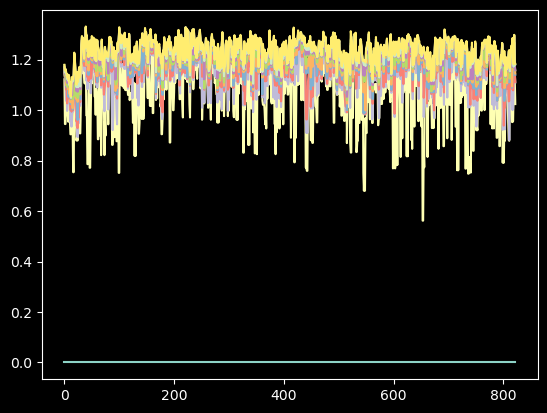

In [474]:
# visualize ball tree
from sklearn.neighbors import BallTree

# get the ball tree
tree = BallTree(X_tfidf.toarray())

# plot the data
plt.plot(tree.query(X_tfidf.toarray(), k=10)[0])
plt.show()


## CSR Matrix

In [434]:
from scipy.sparse import csr_matrix
from sklearn.neighbors import KDTree


# Update the recommend function
def recommend(
        specs,
        n=10,
        k_nearest=10,
        weight:dict=None,
        **kwargs):
        
    # Preprocess the data
    tfidf = TfidfVectorizer(stop_words='english')
    X = tfidf.fit_transform(clean_data['details'].str.replace(r'[^a-zA-Z0-9_]', ' ', regex=True))
    X_sparse = csr_matrix(X)

    # Transform the input specs using TF-IDF vectorizer
    specs_vectorized = tfidf.transform([specs])
    
    for k, v in kwargs.items():
        if k in clean_data.columns:
            X_sparse = hstack((X_sparse, tfidf.transform(clean_data[k].astype(str).str.replace(r'[^a-zA-Z0-9_]', ' ', regex=True))))
            specs_vectorized = hstack((specs_vectorized, tfidf.transform([v])))
    
    # Use a different algorithm for nearest neighbors search, e.g., KDTree
    tree = KDTree(X_sparse.toarray())
    _, indices = tree.query(specs_vectorized.toarray(), k=k_nearest)
    
    # Return recommended phones
    return clean_data.iloc[indices[0]].head(n)


# Get the recommended phone
recommend('', price_min='10000', k_nearest=10)


,brand,colors,model,battery_size,battery_endurance,dimensions_height,dimensions_width,dimensions_depth,weight,os,...,storage_type,price_min,price_max,lazada_ratings,lazada_reviews,build_material,has_wifi,has_bluetooth,has_cardslot,details
phone,,,,,,,,,,,,,,,,,,,,,
samsung_galaxy_a50-9554,Samsung,Black|White|Blue|Coral,Galaxy A50,4000.0,98.000000,158.5,74.7,7.7,166.0,Android,...,UFS,12229.800,16267.500,0.000000,0,Glass|Glass|plastic|plastic,a|b|g|n|ac,5.0,Yes,//www.lazada.com.ph/products/samsung-galaxy-a5...
apple_iphone_13_mini-11104,Apple,Starlight|Midnight|Blue|Pink|Red|Green,iPhone 13 mini,2438.0,75.000000,131.5,64.2,7.7,141.0,iOS,...,NVMe,23464.025,52490.000,4.853659,41,Glass|glass|glass|glass|aluminum,a|b|g|n|ac|6,5.0,No,//www.lazada.com.ph/products/apple-iphone-13-m...
realme_c51-12527,Realme,Mint Green|Carbon Black,C51,5000.0,103.074491,167.2,76.7,8.0,186.0,Android,...,UFS,5299.000,9037.500,4.999565,5855,Glass|plastic|plastic,a|b|g|n|ac,5.0,Yes,www.lazada.com.ph/products/realme-c51-4gb128gb...
samsung_galaxy_a21s-10239,Samsung,Black|White|Blue|Red,Galaxy A21s,5000.0,119.000000,163.7,75.3,8.9,192.0,Android,...,eMMC,10999.000,16999.000,5.000000,1,Glass|plastic|plastic,a|b|g|n|ac,5.0,Yes,//www.lazada.com.ph/products/ready-stocksamsun...
google_pixel_6a-11229,Google,Chalk|Charcoal|Sage,Pixel 6a,4410.0,94.000000,152.2,71.8,8.9,178.0,Android,...,UFS,9793.121,18245.000,4.906977,43,Glass|Glass|aluminum|plastic,a|b|g|n|ac|6e,5.2,No,//www.lazada.com.ph/products/google-pixel-6a-6...
realme_10-11950,Realme,White|Blue,10,5000.0,126.000000,159.9,73.3,8.0,178.0,Android,...,UFS,11999.000,15372.500,0.000000,0,Glass|Glass|plastic|plastic,a|b|g|n|ac,5.3,Yes,//www.lazada.com.ph/products/realme-10-4g-8gb-...
asus_rog_phone_7_ultimate-12224,Asus,Storm White,ROG Phone 7 Ultimate,6000.0,131.000000,173.0,77.0,10.3,239.0,Android,...,UFS,32925.100,69995.000,0.000000,0,Glass|Glass|glass|Glass|aluminum,a|b|g|n|ac|6e|7,5.3,No,//www.lazada.com.ph/products/asus-rog-phone-7-...
samsung_galaxy_a20s-9852,Samsung,Black|Blue|Red|Green,Galaxy A20s,4000.0,82.459593,163.3,77.5,8.0,183.0,Android,...,eMMC,8999.000,15062.500,5.000000,1,Glass|plastic|plastic,b|g|n,4.2,Yes,//www.lazada.com.ph/products/samsung-galaxy-a2...
oppo_find_x5-11378,Oppo,Black|White|Purple,Find X5,4800.0,108.000000,160.3,72.6,8.7,196.0,Android,...,UFS,22999.000,27943.292,0.000000,0,Glass|Glass|glass|aluminum,a|b|g|n|ac|6,5.2,No,//www.lazada.com.ph/products/oppo-find-x5-5g-6...


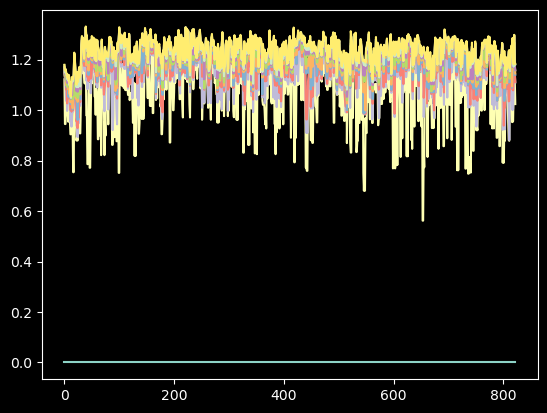

In [476]:
# visualize kd tree with csr matrix
from sklearn.neighbors import KDTree

# get the kd tree
tree = KDTree(X_tfidf.toarray())

# plot the data
plt.plot(tree.query(X_tfidf.toarray(), k=10)[0])
plt.show()



In [53]:
# get the recommended phone

# import the model
from joblib import load
pr = load('phone_recommender.pkl')
pr.recommend('', brand='Apple', os='iOS', price_min='12869.010', price_max='24278.000', k_nearest=10)


,brand,colors,model,battery_size,battery_endurance,dimensions_height,dimensions_width,dimensions_depth,weight,os,...,storage_type,price_min,price_max,lazada_ratings,lazada_reviews,build_material,has_wifi,has_bluetooth,has_cardslot,details
phone,,,,,,,,,,,,,,,,,,,,,
apple_iphone_14_pro-11860,Apple,Space Black|Silver|Gold|Deep Purple,iPhone 14 Pro,3200,86.0,147.5,71.5,7.9,206.0,iOS,...,NVMe,35755.876,64990.0,4.971922,64,Glass|glass|glass|glass|stainless steel,a|b|g|n|ac|6,5.3,No,//www.lazada.com.ph/products/apple-iphone-14-p...
apple_iphone_13_mini-11104,Apple,Starlight|Midnight|Blue|Pink|Red|Green,iPhone 13 mini,2438,75.0,131.5,64.2,7.7,141.0,iOS,...,NVMe,23464.025,52490.0,4.853659,41,Glass|glass|glass|glass|aluminum,a|b|g|n|ac|6,5.0,No,//www.lazada.com.ph/products/apple-iphone-13-m...
apple_iphone_14-11861,Apple,Midnight|Purple|Starlight|Blue|Red|Yellow,iPhone 14,3279,90.0,146.7,71.5,7.8,172.0,iOS,...,NVMe,29462.095,52990.0,5.000000,59,Glass|glass|glass|glass|aluminum,a|b|g|n|ac|6,5.3,No,//www.lazada.com.ph/products/apple-iphone-14-i...
apple_iphone_12-10509,Apple,Black|White|Red|Green|Blue|Purple,iPhone 12,2815,84.0,146.7,71.5,7.4,164.0,iOS,...,NVMe,13886.678,53990.0,4.924797,492,Glass|glass|glass|glass|aluminum,a|b|g|n|ac|6,5.0,No,//www.lazada.com.ph/products/apple-iphone-12-i...
apple_iphone_13_pro_max-11089,Apple,Graphite|Gold|Silver|Sierra Blue|Alpine Green,iPhone 13 Pro Max,4352,121.0,160.8,78.1,7.7,240.0,iOS,...,NVMe,34375.705,76990.0,1.000000,1,Glass|glass|glass|glass|stainless steel,a|b|g|n|ac|6,5.0,No,//www.lazada.com.ph/products/apple-iphone-13-p...
apple_iphone_12_mini-10510,Apple,Black|White|Red|Green|Blue|Purple,iPhone 12 mini,2227,69.0,131.5,64.2,7.4,135.0,iOS,...,NVMe,13807.300,25990.0,5.000000,22,Glass|glass|glass|glass|aluminum,a|b|g|n|ac|6,5.0,No,//www.lazada.com.ph/products/apple-iphone-12-m...
apple_iphone_11_pro_max-9846,Apple,Matte Space Gray|Matte Silver|Matte Gold|Matte...,iPhone 11 Pro Max,3969,102.0,158.0,77.8,8.1,226.0,iOS,...,NVMe,18600.725,43460.0,0.000000,0,Glass|glass|glass|glass|stainless steel,a|b|g|n|ac|6,5.0,No,//www.lazada.com.ph/products/11-promax-64gbbra...
apple_iphone_13-11103,Apple,Starlight|Midnight|Blue|Pink|Red|Green,iPhone 13,3240,89.0,146.7,71.5,7.7,174.0,iOS,...,NVMe,21687.523,52990.0,4.940397,151,Glass|glass|glass|glass|aluminum,a|b|g|n|ac|6,5.0,No,//www.lazada.com.ph/products/apple-iphone-13-i...
apple_iphone_11-9848,Apple,Black|Green|Yellow|Purple|Red|White,iPhone 11,3110,94.0,150.9,75.7,8.3,194.0,iOS,...,NVMe,12745.200,37990.0,4.939130,805,Glass|glass|glass|glass|aluminum,a|b|g|n|ac|6,5.0,No,//www.lazada.com.ph/products/apple-iphone-11-l...


ValueError: X has 1484 features, but NearestNeighbors is expecting 13385 features as input.